---
title: 'Calor extremo: Pergamino, Provincia de Buenos Aires'
author: Nissim Lebovits
date: 26-11-2025
---

## Overview

## Context

In [4]:
import planetary_computer
import pystac_client
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster
from odc.stac import configure_rio, stac_load

import geopandas as gpd

from pathlib import Path
from matplotlib import colors
import requests


from io import BytesIO
from owslib.wfs import WebFeatureService
import pandas as pd
import duckdb
from dask.diagnostics import ProgressBar
import rioxarray as rio


USE_CRS = "EPSG:5347"
CRS_WGS84 = "EPSG:4326"

RUTA_DATOS = Path("/home/nissim/Documents/dev/datos-escala-humana/es/cookbooks")

In [5]:
base_url = "https://wms.ign.gob.ar/geoserver/ign/ows"

if (RUTA_DATOS / "municipios.geojson").exists():
    munis = gpd.read_file(RUTA_DATOS / "municipios.geojson")
else:
    params = {
        "service": "WFS",
        "version": "2.0.0",
        "request": "GetFeature",
        "typename": "ign:municipio",
        "outputFormat": "application/json",
        "srsname": "EPSG:4326",
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        munis = gpd.read_file(BytesIO(response.content))
        munis.to_file(RUTA_DATOS / "municipios.geojson", driver="GeoJSON")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

pergamino = munis[munis["nam"] == "Pergamino"]
pergamino = pergamino.to_crs(USE_CRS)

bbox_pergamino_4326 = pergamino.to_crs(CRS_WGS84).total_bounds

In [6]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))

    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

## Climate projections

In [7]:
import cdsapi
import xarray as xr
import pandas as pd
import zipfile
import os
from pathlib import Path

# Define experiments to download
experiments = {
    'historical': {'experiment': 'historical', 'period': None},
    'ssp1_2_6': {'experiment': 'ssp1_2_6', 'period': '2015-2100'},
    'ssp2_4_5': {'experiment': 'ssp2_4_5', 'period': '2015-2100'},
    'ssp5_8_5': {'experiment': 'ssp5_8_5', 'period': '2015-2100'},
}

c = cdsapi.Client()
bbox = bbox_pergamino_4326
center_lon = (bbox[0] + bbox[2]) / 2
center_lat = (bbox[1] + bbox[3]) / 2

# Dictionary to store processed data
all_data = {}

for exp_name, exp_config in experiments.items():
    print(f"\nProcessing {exp_name}...")
    
    zip_file = f"ipcc_atlas_{exp_name}.zip"
    extract_dir = f"ipcc_{exp_name}_data"
    
    # Download if not exists
    if not Path(zip_file).exists():
        print(f"  Downloading {exp_name}...")
        request = {
            "origin": "cmip6",
            "experiment": exp_config['experiment'],
            "domain": "global",
            "variable": "monthly_count_of_days_with_maximum_temperature_above_35_c",
        }
        if exp_config['period']:
            request['period'] = exp_config['period']
        
        c.retrieve("projections-climate-atlas", request, zip_file)
    else:
        print(f"  File exists, skipping download")
    
    # Extract and process
    if not Path(extract_dir).exists():
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
    
    nc_files = [f for f in os.listdir(extract_dir) if f.endswith('.nc')]
    actual_nc_file = os.path.join(extract_dir, nc_files[0])
    
    # Load and subset
    ds = xr.open_dataset(actual_nc_file)
    ds_subset = ds.sel(lon=center_lon, lat=center_lat, method='nearest')
    tx35_mean = ds_subset['tx35'].mean(dim='member')
    
    # Convert to annual data
    df = tx35_mean.to_dataframe().reset_index()
    df['year'] = df['time'].dt.year
    annual_days = df.groupby('year')['tx35'].sum().reset_index()
    annual_days.columns = ['year', 'days_over_35C']
    
    all_data[exp_name] = annual_days
    print(f"  Processed {len(annual_days)} years: {annual_days['year'].min()}-{annual_days['year'].max()}")

print("\nAll data loaded:")
for exp_name, data in all_data.items():
    print(f"  {exp_name}: {len(data)} years")


Processing historical...
  File exists, skipping download


/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 165 years: 1850-2014

Processing ssp1_2_6...
  File exists, skipping download


/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

Processing ssp2_4_5...
  File exists, skipping download


/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

Processing ssp5_8_5...
  File exists, skipping download


/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'tx35' has multiple fill values {np.float32(1.0384594e+34), np.float32(-1.7014118e+38)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


  Processed 86 years: 2015-2100

All data loaded:
  historical: 165 years
  ssp1_2_6: 86 years
  ssp2_4_5: 86 years
  ssp5_8_5: 86 years


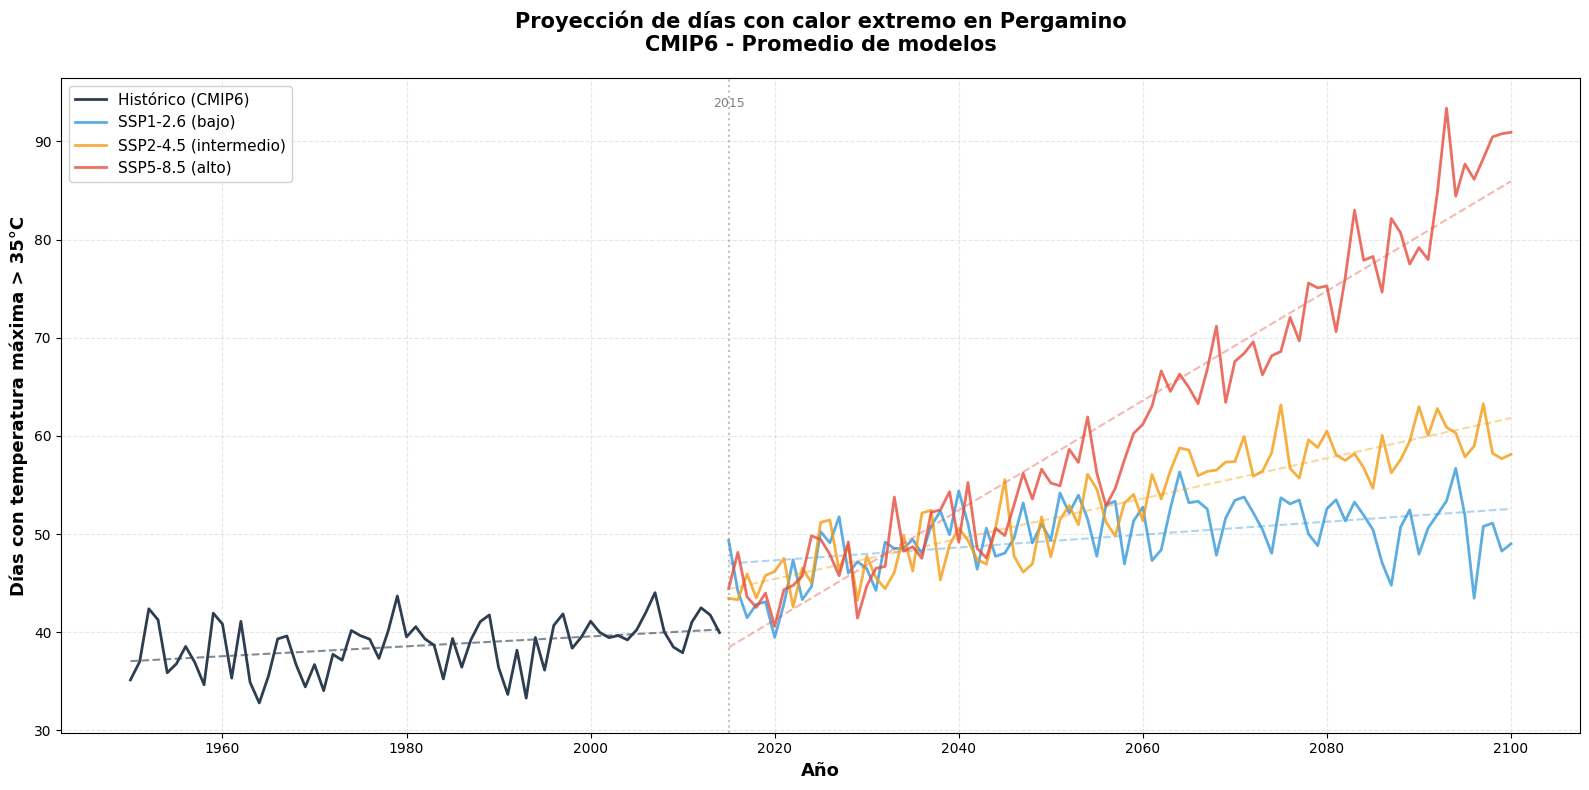


Estadísticas por período:

Histórico (1950-2014): 38.7 días/año
  Tendencia: 0.050 días/año

SSP1-2.6 (bajo):
  2015-2050: 47.8 días/año
  2051-2100: 51.2 días/año
  Tendencia: 0.065 días/año
  Último año (2100): 49.0 días/año

SSP2-4.5 (intermedio):
  2015-2050: 47.5 días/año
  2051-2100: 57.1 días/año
  Tendencia: 0.205 días/año
  Último año (2100): 58.1 días/año

SSP5-8.5 (alto):
  2015-2050: 48.7 días/año
  2051-2100: 71.9 días/año
  Tendencia: 0.559 días/año
  Último año (2100): 90.9 días/año



In [8]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Filter historical to 1950+
historical_1950 = all_data['historical'][all_data['historical']['year'] >= 1950].copy()

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

# Define colors for scenarios
colors = {
    'historical': '#2c3e50',
    'ssp1_2_6': '#3498db',  # Blue - low emissions
    'ssp2_4_5': '#f39c12',  # Orange - middle
    'ssp5_8_5': '#e74c3c',  # Red - high emissions
}

labels = {
    'historical': 'Histórico (CMIP6)',
    'ssp1_2_6': 'SSP1-2.6 (bajo)',
    'ssp2_4_5': 'SSP2-4.5 (intermedio)',
    'ssp5_8_5': 'SSP5-8.5 (alto)',
}

# Plot historical
ax.plot(historical_1950['year'], historical_1950['days_over_35C'], 
        linewidth=2, color=colors['historical'], label=labels['historical'])

# Add historical trend line
z_hist = np.polyfit(historical_1950['year'], historical_1950['days_over_35C'], 1)
p_hist = np.poly1d(z_hist)
ax.plot(historical_1950['year'], p_hist(historical_1950['year']), 
        "--", linewidth=1.5, color=colors['historical'], alpha=0.6)

# Plot projections
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]
    ax.plot(data['year'], data['days_over_35C'], 
            linewidth=2, color=colors[scenario], label=labels[scenario], alpha=0.8)
    
    # Add trend line for each scenario
    z = np.polyfit(data['year'], data['days_over_35C'], 1)
    p = np.poly1d(z)
    ax.plot(data['year'], p(data['year']), 
            "--", linewidth=1.5, color=colors[scenario], alpha=0.4)

# Styling
ax.set_xlabel('Año', fontsize=13, fontweight='bold')
ax.set_ylabel('Días con temperatura máxima > 35°C', fontsize=13, fontweight='bold')
ax.set_title('Proyección de días con calor extremo en Pergamino\nCMIP6 - Promedio de modelos', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)

# Add vertical line at 2015 to mark transition
ax.axvline(x=2015, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax.text(2015, ax.get_ylim()[1] * 0.98, '2015', 
        ha='center', va='top', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

# Print statistics
print("\nEstadísticas por período:\n")
print(f"Histórico (1950-2014): {historical_1950['days_over_35C'].mean():.1f} días/año")
print(f"  Tendencia: {z_hist[0]:.3f} días/año\n")

for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    data = all_data[scenario]
    slope = np.polyfit(data['year'], data['days_over_35C'], 1)[0]
    print(f"{labels[scenario]}:")
    print(f"  2015-2050: {data[data['year'] <= 2050]['days_over_35C'].mean():.1f} días/año")
    print(f"  2051-2100: {data[data['year'] > 2050]['days_over_35C'].mean():.1f} días/año")
    print(f"  Tendencia: {slope:.3f} días/año")
    print(f"  Último año (2100): {data[data['year'] == 2100]['days_over_35C'].values[0]:.1f} días/año\n")

In [9]:
# Calculate historical baseline (1950-2014)
hist_baseline = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C'].mean()

print(f"Histórico (1950-2014): {hist_baseline:.1f} días/año\n")

# Calculate % increase for near-term (2020-2050)
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    near_term = all_data[scenario][(all_data[scenario]['year'] >= 2020) & 
                                    (all_data[scenario]['year'] <= 2050)]
    near_avg = near_term['days_over_35C'].mean()
    pct_increase = ((near_avg - hist_baseline) / hist_baseline) * 100
    
    print(f"{labels[scenario]} (2020-2050):")
    print(f"  Promedio: {near_avg:.1f} días/año")
    print(f"  Aumento: +{near_avg - hist_baseline:.1f} días ({pct_increase:+.1f}%)\n")

Histórico (1950-2014): 38.7 días/año

SSP1-2.6 (bajo) (2020-2050):
  Promedio: 48.4 días/año
  Aumento: +9.7 días (+25.1%)

SSP2-4.5 (intermedio) (2020-2050):
  Promedio: 48.0 días/año
  Aumento: +9.3 días (+24.2%)

SSP5-8.5 (alto) (2020-2050):
  Promedio: 49.3 días/año
  Aumento: +10.7 días (+27.6%)



In [10]:
# Calculate historical baseline (1950-2014)
hist_baseline = all_data['historical'][all_data['historical']['year'] >= 1950]['days_over_35C'].mean()

print(f"Histórico (1950-2014): {hist_baseline:.1f} días/año\n")

# Calculate % increase for each scenario
for scenario in ['ssp1_2_6', 'ssp2_4_5', 'ssp5_8_5']:
    # End of century (2070-2100)
    eoc_avg = all_data[scenario][all_data[scenario]['year'] >= 2070]['days_over_35C'].mean()
    pct_increase = ((eoc_avg - hist_baseline) / hist_baseline) * 100
    
    print(f"{labels[scenario]} (2070-2100):")
    print(f"  Promedio: {eoc_avg:.1f} días/año")
    print(f"  Aumento: +{eoc_avg - hist_baseline:.1f} días ({pct_increase:+.1f}%)\n")

Histórico (1950-2014): 38.7 días/año

SSP1-2.6 (bajo) (2070-2100):
  Promedio: 51.0 días/año
  Aumento: +12.3 días (+31.8%)

SSP2-4.5 (intermedio) (2070-2100):
  Promedio: 58.8 días/año
  Aumento: +20.1 días (+52.0%)

SSP5-8.5 (alto) (2070-2100):
  Promedio: 78.4 días/año
  Aumento: +39.8 días (+102.8%)



## Exploratory analysis

### Descriptive stats for LST

In [11]:
# Connect to Planetary Computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

cluster = LocalCluster(
    processes=True,  # Critical: use processes, not threads
    n_workers=8,  # Use half your cores for workers
    threads_per_worker=2,  # 2 threads per worker = 16 total
    memory_limit="6GB",  # 8 workers × 6GB = 48GB, leaves headroom
)
client = Client(cluster)
print(f"Dask dashboard: {client.dashboard_link}")
configure_rio(cloud_defaults=True, client=client)

# Query for last 5 years
bbox = bbox_pergamino_4326
datetime = "2020-01-01/2025-01-01"  # Last 5 years
cloudy_less_than = 20  # You might need to be less strict for 5 years of data

query = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox,
    datetime=datetime,
    query={"eo:cloud_cover": {"lt": cloudy_less_than}},
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

/home/nissim/Documents/dev/datos-escala-humana/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45205 instead
  warnings.warn(


Dask dashboard: http://127.0.0.1:45205/status
Found: 488 datasets


In [12]:
# Define output file path (same directory as notebook)
import os

notebook_dir = Path(os.path.dirname(os.path.abspath("pergamino.ipynb")))
lst_tif_path = notebook_dir / "LST_max_pergamino.tif"

# Check if file exists, otherwise compute
if lst_tif_path.exists():
    print(f"Loading existing LST data from {lst_tif_path}")
    LST_max_computed = rio.open_rasterio(lst_tif_path)
    # Squeeze out any extra dimensions if needed
    if len(LST_max_computed.dims) > 2:
        LST_max_computed = LST_max_computed.squeeze()
else:
    print("Computing LST from scratch...")
    # Load only thermal band and QA band
    crs = "epsg:3857"
    yy = stac_load(
        items,
        bands=("lwir11", "qa_pixel"),
        crs=crs,
        resolution=30,
        chunks={"time": 10},  # Process in chunks of 10 time steps
        groupby="landsat:scene_id",
        bbox=bbox_pergamino_4326,
    )

    # Create cloud mask function
    def create_cloud_mask(qa_band):
        """Mask clouds and cloud shadows"""
        # Bit 3: Cloud, Bit 4: Cloud Shadow
        cloud_mask = (qa_band & 0b11000) == 0
        return cloud_mask

    # Apply cloud mask
    yy_masked = yy.where(create_cloud_mask(yy.qa_pixel))

    # Convert thermal band to LST in Celsius
    LST_kelvin = yy_masked["lwir11"] * 0.00341802 + 149.0
    LST_celsius = LST_kelvin - 273.15

    # Calculate maximum LST per pixel over all time steps
    LST_max = LST_celsius.max(dim="time")

    # Before compute()
    print("Computing maximum LST...")
    print(f"Dashboard: {client.dashboard_link}")
    with ProgressBar():
        LST_max_computed = LST_max.compute()

    # Save to file
    print(f"Saving LST data to {lst_tif_path}")
    LST_max_computed.rio.to_raster(lst_tif_path)

Loading existing LST data from /home/nissim/Documents/dev/datos-escala-humana/es/cookbooks/LST_max_pergamino.tif


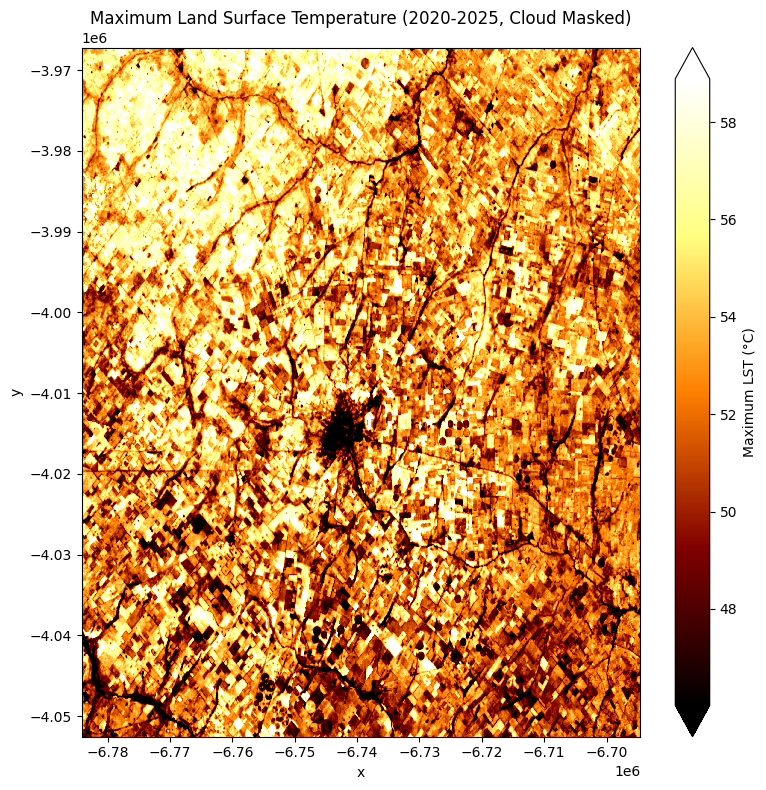

In [13]:
# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))
LST_max_computed.plot.imshow(
    ax=ax,
    cmap="afmhot",
    cbar_kwargs={"label": "Maximum LST (°C)"},
    robust=True,  # Use 2nd and 98th percentiles for color scaling
)
ax.set_title("Maximum Land Surface Temperature (2020-2025, Cloud Masked)")
plt.tight_layout()
plt.show()

In [14]:
# Optional: Save to file
# LST_max_computed.rio.to_raster(RUTA_DATOS / "LST_max_5years.tif")

# Print some statistics
print("\nMaximum LST Statistics:")
print(f"  Overall max: {float(LST_max_computed.max().values):.2f}°C")
print(f"  Overall min: {float(LST_max_computed.min().values):.2f}°C")
print(f"  Mean of maximums: {float(LST_max_computed.mean().values):.2f}°C")
print(f"  Median of maximums: {float(LST_max_computed.median().values):.2f}°C")


Maximum LST Statistics:
  Overall max: 65.36°C
  Overall min: 33.75°C
  Mean of maximums: 52.91°C
  Median of maximums: 52.91°C


### LST by land cover class

In [15]:
# Load the cloud GeoTIFF clipped to your GeoDataFrame
suelo_2022_ruta = "https://storage.googleapis.com/mapbiomas-public/initiatives/argentina/collection-1/coverage/argentina_coverage_2022.tif"

# 1. Use your existing Dask cluster for parallel reads
suelo_2022 = rio.open_rasterio(
    suelo_2022_ruta,
    chunks={"x": 2048, "y": 2048},  # Larger chunks = fewer tasks, faster
    lock=False,  # Critical: allows parallel HTTP reads from GCS
)

# For the clip/compute operation
with ProgressBar():
    # 2. Clip efficiently
    suelo_2022 = suelo_2022.rio.clip(
        pergamino.geometry.values,
        pergamino.crs,
        from_disk=True,
        all_touched=False,  # Only pixels with centers inside
    )

In [16]:
# Define the detailed categories and colors
categories_detailed = {
    "Leñosa cerrada": {"ids": [3], "color": "#1f8d49"},
    "Leñosa abierta": {"ids": [4], "color": "#7dc975"},
    "Leñosa dispersa": {"ids": [45], "color": "#807a40"},
    "Leñosa inundable": {"ids": [6], "color": "#026975"},
    "Vegetación no leñosa inundable": {"ids": [11], "color": "#519799"},
    "Pastizal": {"ids": [12], "color": "#d6bc74"},
    "Estepa": {"ids": [63], "color": "#ebf8b5"},
    "Pastura": {"ids": [15], "color": "#edde8e"},
    "Agricultura": {"ids": [18], "color": "#e974ed"},
    "Plantación forestal": {"ids": [9], "color": "#7a5900"},
    "Cultivo arbustivo": {"ids": [36], "color": "#d082de"},
    "Mosaico agropecuario": {"ids": [21], "color": "#ffefc3"},
    "Área sin vegetación": {"ids": [22], "color": "#d4271e"},
    "Río, lago u océano": {"ids": [33], "color": "#2532e4"},
    "Hielo y nieve en superficie": {"ids": [34], "color": "#93dfe6"},
    "No observado": {"ids": [27], "color": "#ffffff"},
}

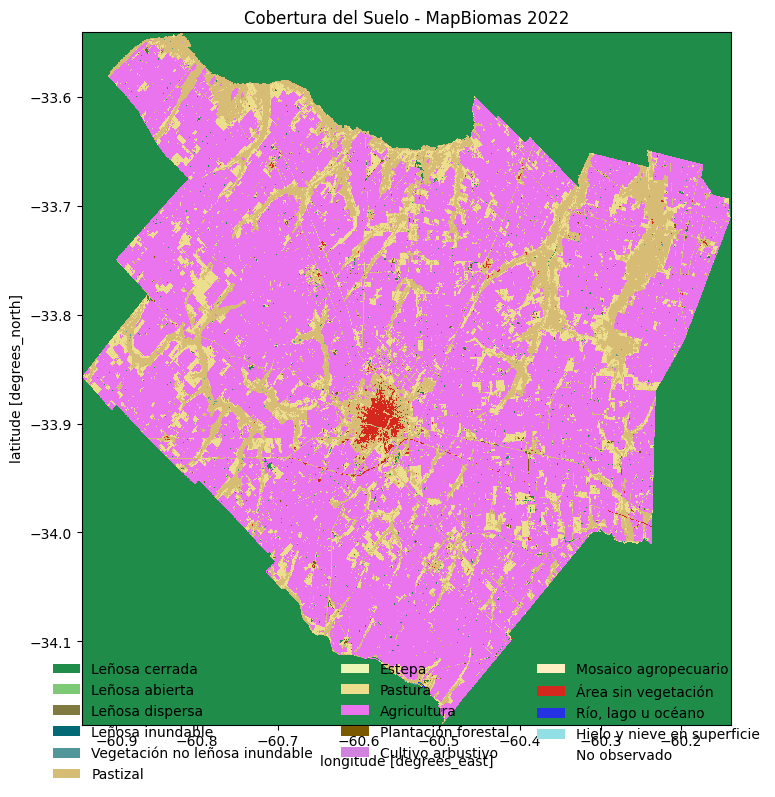

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Create colormap from detailed categories
colors = {}
for category, info in categories_detailed.items():
    for pixel_id in info["ids"]:
        colors[pixel_id] = info["color"]

cmap = mcolors.ListedColormap([colors[i] for i in sorted(colors.keys())])
bounds = sorted(colors.keys())
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the raster
im = suelo_2022.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create custom legend from detailed categories
legend_labels = {}
for category, info in categories_detailed.items():
    legend_labels[info["color"]] = category

# Add legend below the map
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, facecolor=color, label=label)
    for color, label in legend_labels.items()
]
ax.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.1),
    ncol=3,
    frameon=False,
)

plt.title("Cobertura del Suelo - MapBiomas 2022")
plt.tight_layout()
plt.show()

In [18]:
# 1. Reproject land cover to match LST grid (if needed)
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# 2. Flatten both arrays and create DataFrame
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

df = pd.DataFrame({"LST": lst_flat, "LandCover": landcover_flat})

# 3. Filter out invalid values
df_clean = df[
    (df["LandCover"] > 0)  # Remove 0
    & (df["LandCover"] < 255)  # Remove 255
    & (~df["LandCover"].isna())  # Remove NaN
    & (~df["LST"].isna())  # Remove LST NaN
].copy()

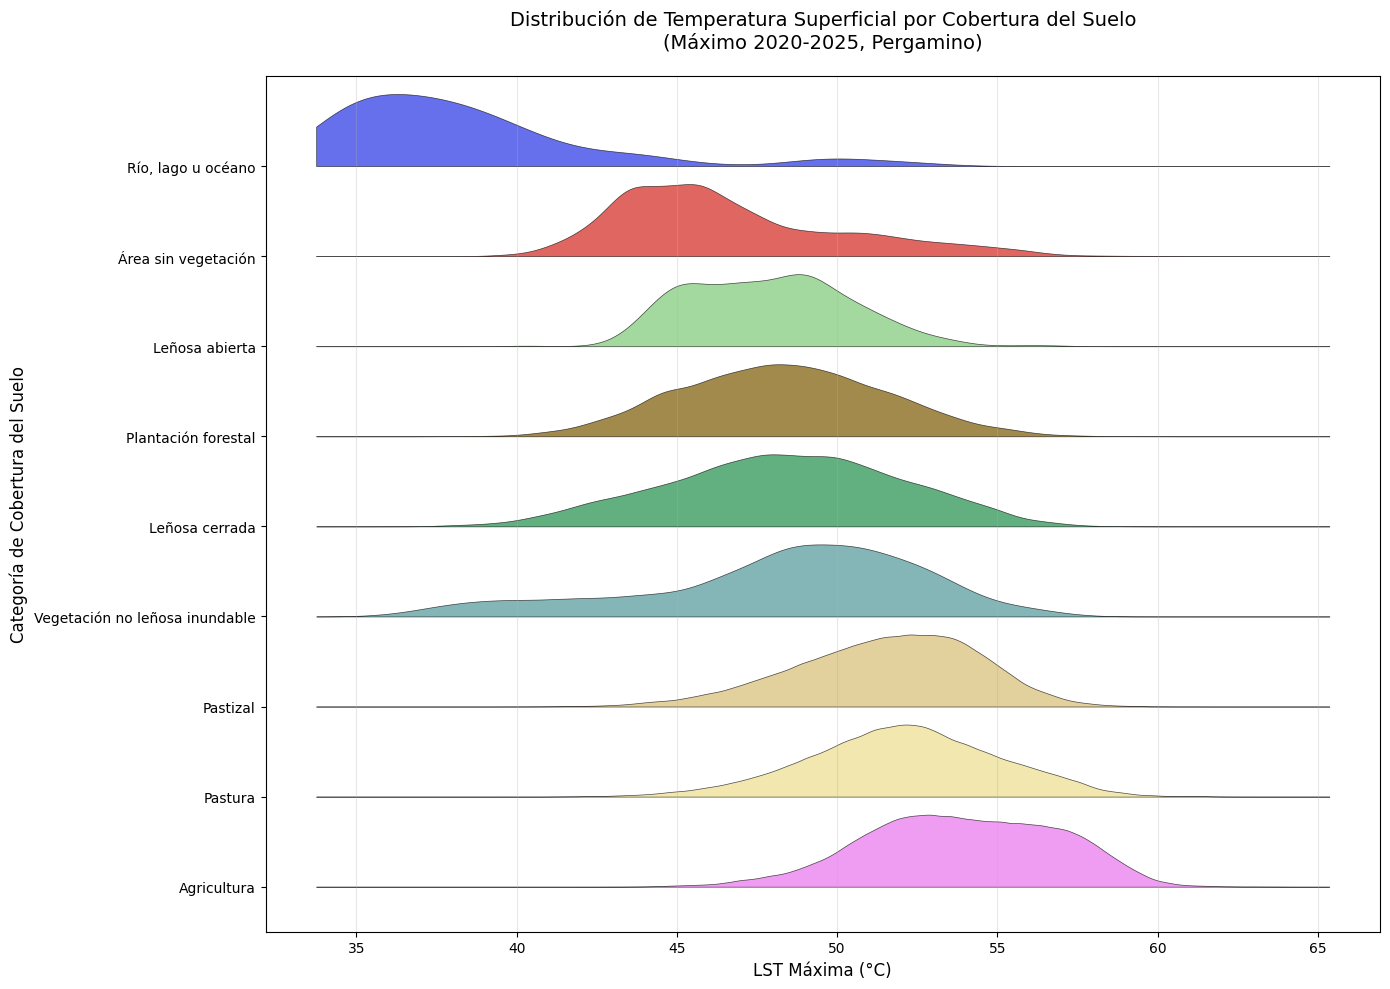

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Create mapping from IDs to category names
id_to_name = {}
for category, details in categories_detailed.items():
    for id_val in details["ids"]:
        id_to_name[id_val] = category

# Add readable names to dataframe
df_clean["Category"] = df_clean["LandCover"].astype(int).map(id_to_name)

# Sort by median LST for better visualization
category_order = (
    df_clean.groupby("Category")["LST"].median().sort_values(ascending=False).index
)

# Create color mapping from categories
category_colors = {cat: details["color"] for cat, details in categories_detailed.items()}

# Create density plots
fig, ax = plt.subplots(figsize=(14, 10))

# Plot density for each category on separate rows
for i, category in enumerate(category_order):
    data = df_clean[df_clean["Category"] == category]["LST"].dropna()
    
    if len(data) > 1:
        # Calculate kernel density estimation
        density = stats.gaussian_kde(data)
        xs = np.linspace(df_clean["LST"].min(), df_clean["LST"].max(), 500)
        density_values = density(xs)
        
        # Normalize and offset density for this row
        density_values = density_values / density_values.max() * 0.8
        
        # Plot density curve starting from row baseline
        ax.fill_between(
            xs,
            i,
            i + density_values,
            alpha=0.7,
            color=category_colors[category],
            edgecolor='black',
            linewidth=0.5
        )

ax.set_yticks(range(len(category_order)))
ax.set_yticklabels(category_order)
ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Categoría de Cobertura del Suelo", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Cobertura del Suelo\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="x", alpha=0.3)
ax.set_ylim(-0.5, len(category_order))
plt.tight_layout()
plt.show()

### LST by type of populated area

In [20]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:aglomerados_urbanos"

bbox_pergamino = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox_pergamino[0]},{bbox_pergamino[1]},{bbox_pergamino[2]},{bbox_pergamino[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    aglomerados_urbanos = gpd.read_file(BytesIO(response.content))

    aglomerados_urbanos = aglomerados_urbanos.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Total pixels in classified areas: 76,681

Pixels per classification:
clasificacion
urbana                 42239
urbano en ruralidad    17418
periurbana             17024
Name: count, dtype: int64


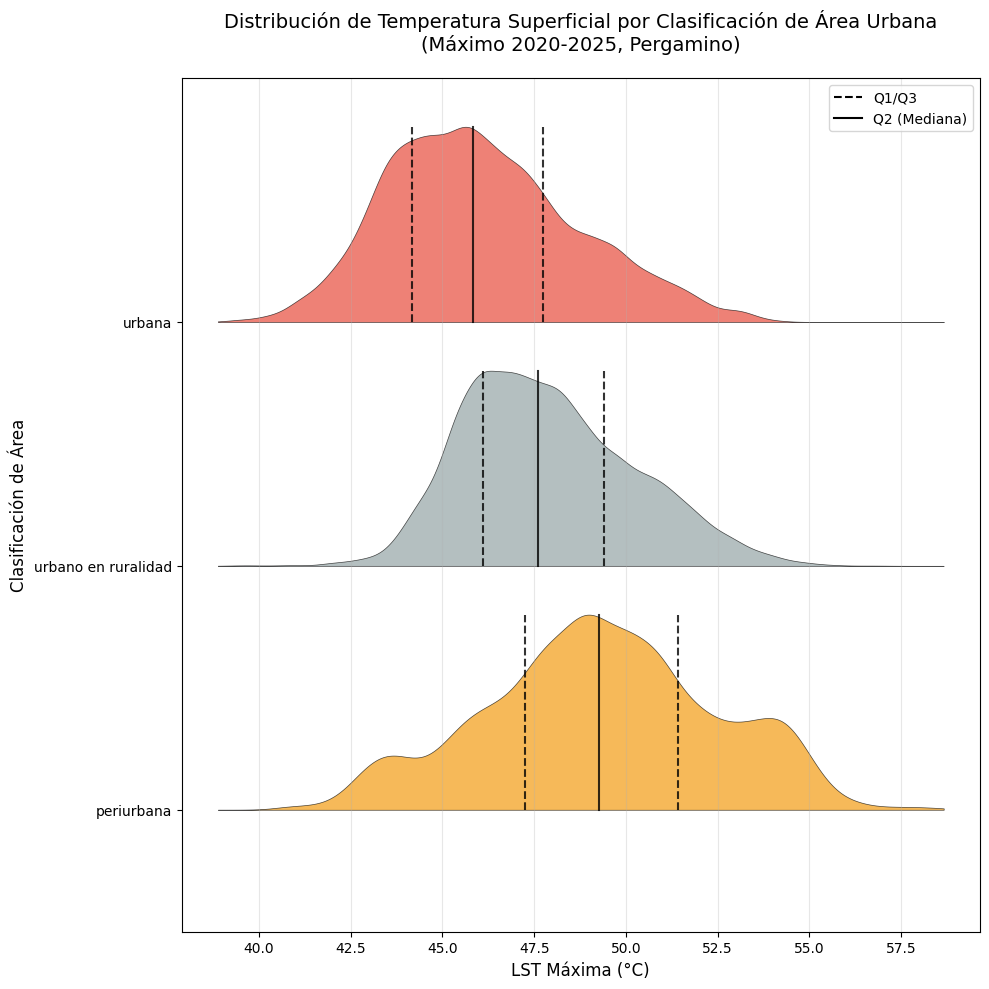


Mean LST by classification:
clasificacion
periurbana             49.311142
urbano en ruralidad    47.873032
urbana                 46.097038
Name: LST, dtype: float32


In [ ]:
import pandas as pd
import numpy as np
from rasterio import features
from scipy import stats
import matplotlib.pyplot as plt

# 1. Rasterize the urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

# Map classifications to numeric codes
clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3,
    'rural': 4
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

# Rasterize classifications
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

clasificacion_raster = features.rasterize(
    [(geom, code) for geom, code in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype='uint8'
)

# 2. Create dataframe with LST values and their classification
clasificacion_flat = clasificacion_raster.flatten()
lst_flat = LST_max_computed.values.flatten()

# Filter to only pixels within a classification zone (code > 0) and valid LST
valid_mask = (clasificacion_flat > 0) & (~np.isnan(lst_flat))

df_lst_class = pd.DataFrame({
    'code': clasificacion_flat[valid_mask],
    'LST': lst_flat[valid_mask]
})

# Map codes back to classification names
code_to_clasificacion = {v: k for k, v in clasificacion_to_code.items()}
df_lst_class['clasificacion'] = df_lst_class['code'].map(code_to_clasificacion)

# 3. Create density plots
clasificacion_order = df_lst_class.groupby('clasificacion')['LST'].mean().sort_values(ascending=False).index

clasificacion_colors = {
    'urbana': '#e74c3c',
    'rural': '#2ecc71',
    'periurbana': '#f39c12',
    'urbano en ruralidad': '#95a5a6'
}

fig, ax = plt.subplots(figsize=(10, 10))

for i, clasificacion in enumerate(clasificacion_order):
    data = df_lst_class[df_lst_class['clasificacion'] == clasificacion]['LST'].dropna()
    
    if len(data) > 1:
        # Calculate kernel density estimation
        density = stats.gaussian_kde(data)
        xs = np.linspace(df_lst_class['LST'].min(), df_lst_class['LST'].max(), 500)
        density_values = density(xs)
        
        # Normalize and offset density for this row
        density_values = density_values / density_values.max() * 0.8
        
        # Plot density curve starting from row baseline
        ax.fill_between(
            xs,
            i,
            i + density_values,
            alpha=0.7,
            color=clasificacion_colors.get(clasificacion, '#95a5a6'),
            edgecolor='black',
            linewidth=0.5
        )
        
        # Calculate and plot quartiles
        q1 = data.quantile(0.25)
        q2 = data.quantile(0.50)  # median
        q3 = data.quantile(0.75)
        
        # Plot quartile lines
        for q, style in [(q1, '--'), (q2, '-'), (q3, '--')]:
            ax.plot([q, q], [i, i + 0.8], 
                   color='black', 
                   linestyle=style, 
                   linewidth=1.5, 
                   alpha=0.8)

ax.set_yticks(range(len(clasificacion_order)))
ax.set_yticklabels(clasificacion_order)
ax.set_xlabel("LST Máxima (°C)", fontsize=12)
ax.set_ylabel("Clasificación de Área", fontsize=12)
ax.set_title(
    "Distribución de Temperatura Superficial por Clasificación de Área Urbana\n(Máximo 2020-2025, Pergamino)",
    fontsize=14,
    pad=20,
)
ax.grid(axis="x", alpha=0.3)
ax.set_ylim(-0.5, len(clasificacion_order))

# Add legend for quartile lines
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label='Q1/Q3'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Q2 (Mediana)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nMean LST by classification:")
print(df_lst_class.groupby('clasificacion')['LST'].mean().sort_values(ascending=False))

### LST by tree canopy cover by populated area

Loaded 45825 tree features
Grid: (2845, 2985), Pixel size: 30.0m, Pixel area: 900.0 m²
Rasterizing tree canopy...
Canopy coverage range: 0.00% - 100.00%
Mean coverage: 0.15%


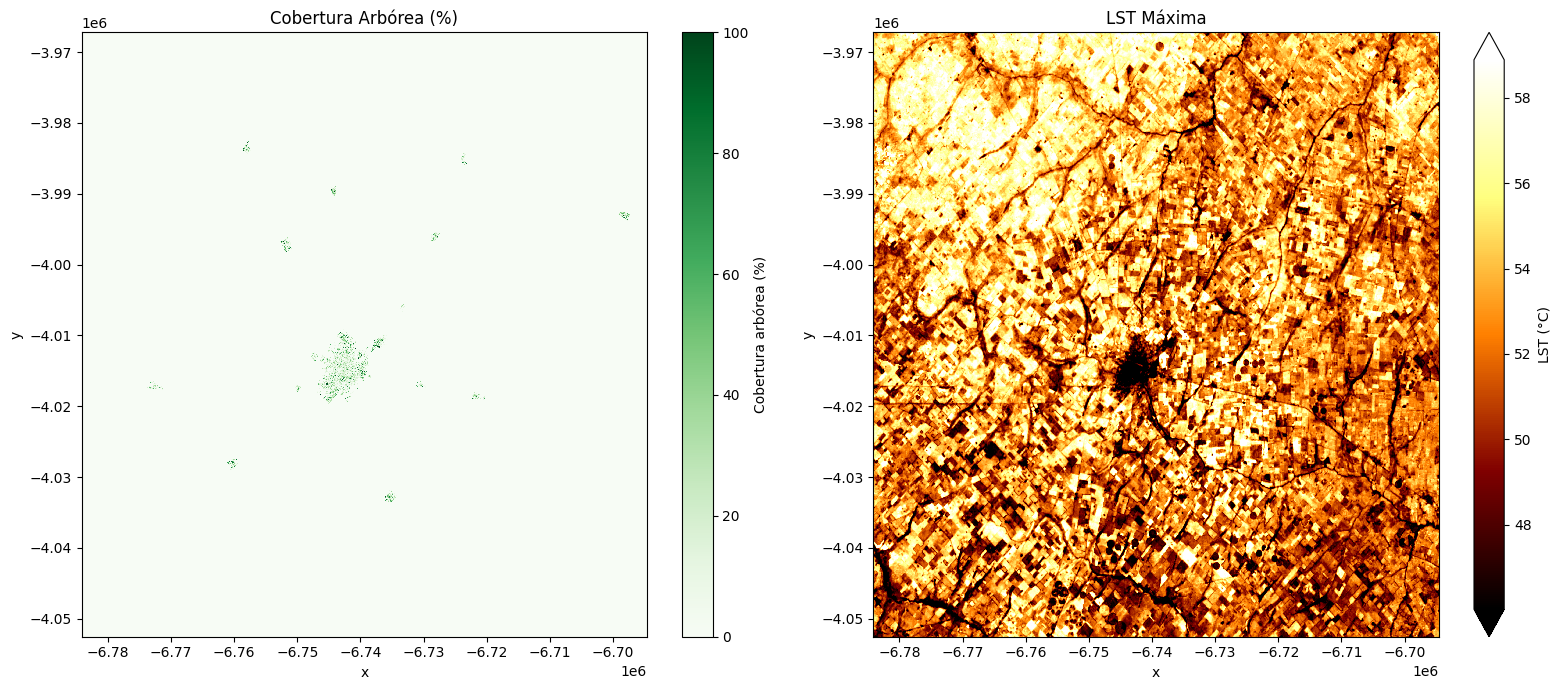

Píxeles urbanos válidos: 32,779


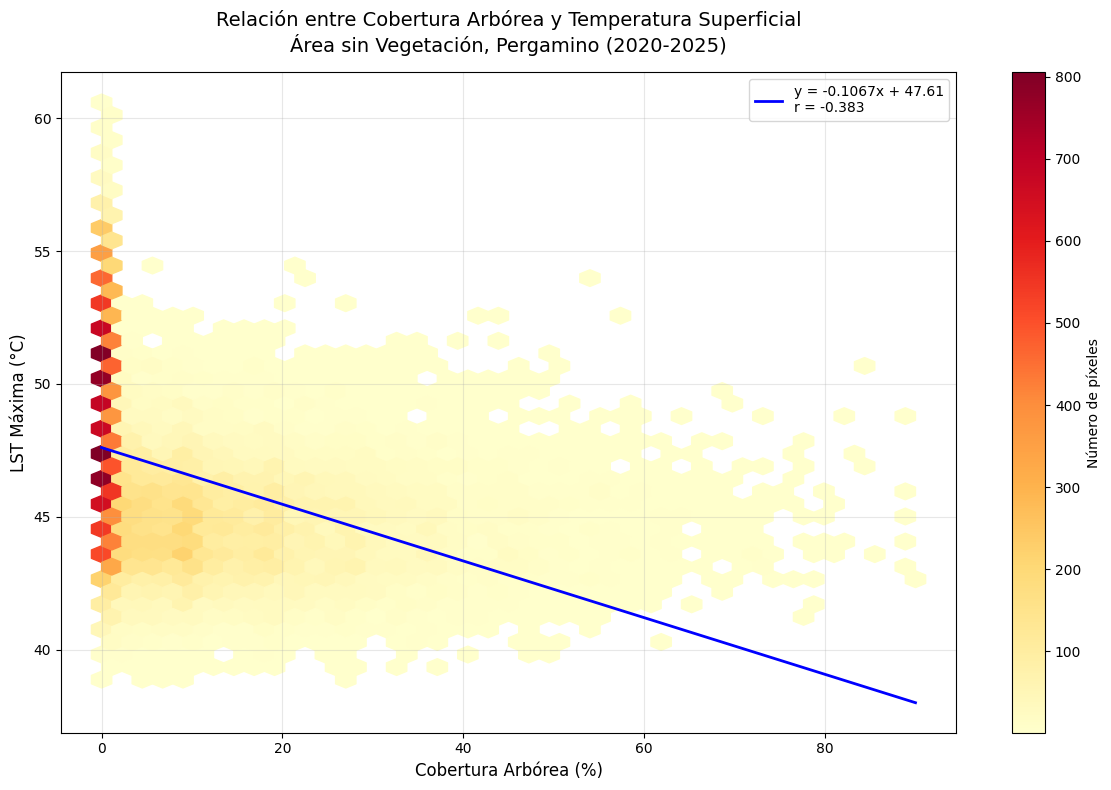


Correlación: -0.383
Cobertura arbórea:
  Percentiles: 25%=0.0%, 50%=4.0%, 75%=14.0%, 95%=35.0%


In [24]:
import requests
import geopandas as gpd
from rasterio import features
import numpy as np
from scipy import stats

# Load tree canopy data from WFS
arbolado_layer_name = "publico:cobertura_arbolado_urbano"

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": arbolado_layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    arbolado_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(arbolado_gdf)} tree features")
    arbolado_gdf = arbolado_gdf.to_crs(pergamino.crs)
else:
    print(f"Error: {response.status_code}")
    print(response.text)

# 1. Align canopy to LST grid
cobertura_aligned = arbolado_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get grid info from LST
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
pixel_area = pixel_size**2
print(f"Grid: {shape}, Pixel size: {pixel_size}m, Pixel area: {pixel_area} m²")

# 3. Create empty array for canopy coverage
canopy_coverage = np.zeros(shape, dtype=np.float32)

# 4. Rasterize: sum of intersecting canopy areas per pixel
print("Rasterizing tree canopy...")
upscale = 10
fine_shape = (shape[0] * upscale, shape[1] * upscale)
fine_transform = transform * transform.scale(1 / upscale, 1 / upscale)

# Rasterize canopy as binary mask at fine resolution
fine_mask = features.rasterize(
    shapes=cobertura_aligned.geometry,
    out_shape=fine_shape,
    transform=fine_transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 5. Aggregate to target resolution (percentage coverage)
canopy_percent = (
    fine_mask.reshape(shape[0], upscale, shape[1], upscale).mean(axis=(1, 3)) * 100
)

# 6. Create xarray aligned with LST
canopy_coverage_xr = LST_max_computed.copy()
canopy_coverage_xr.values = canopy_percent
canopy_coverage_xr.name = "canopy_coverage_percent"
print(
    f"Canopy coverage range: {canopy_coverage_xr.min().values:.2f}% - {canopy_coverage_xr.max().values:.2f}%"
)
print(f"Mean coverage: {canopy_coverage_xr.mean().values:.2f}%")

# 7. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
canopy_coverage_xr.plot(
    ax=ax1,
    cmap="Greens",
    vmin=0,
    vmax=100,
    cbar_kwargs={"label": "Cobertura arbórea (%)"},
)
ax1.set_title("Cobertura Arbórea (%)")
LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")
plt.tight_layout()
plt.show()

# 1. Flatten all rasters
canopy_flat = canopy_coverage_xr.values.flatten()
lst_flat = LST_max_computed.values.flatten()
landcover_flat = suelo_aligned.values.flatten()

# 2. Filter for urban pixels (ID 22) with valid data
urban_mask = (landcover_flat == 22) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))
lst_urban = lst_flat[urban_mask]
canopy_urban = canopy_flat[urban_mask]
print(f"Píxeles urbanos válidos: {len(lst_urban):,}")

# 3. Scatterplot
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.hexbin(canopy_urban, lst_urban, gridsize=40, cmap="YlOrRd", mincnt=1)
plt.colorbar(scatter, ax=ax, label="Número de píxeles")

# 4. Add linear regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(canopy_urban, lst_urban)
x_line = np.linspace(canopy_urban.min(), canopy_urban.max(), 100)
y_line = slope * x_line + intercept
ax.plot(
    x_line,
    y_line,
    "b-",
    linewidth=2,
    label=f"y = {slope:.4f}x + {intercept:.2f}\nr = {r_value:.3f}",
)
ax.legend()
ax.set_xlabel("Cobertura Arbórea (%)", fontsize=12)
ax.set_ylabel("LST Máxima (°C)", fontsize=12)
ax.set_title(
    "Relación entre Cobertura Arbórea y Temperatura Superficial\nÁrea sin Vegetación, Pergamino (2020-2025)",
    fontsize=14,
    pad=15,
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Stats
correlation = np.corrcoef(canopy_urban, lst_urban)[0, 1]
print(f"\nCorrelación: {correlation:.3f}")
print("Cobertura arbórea:")
print(
    f"  Percentiles: 25%={np.percentile(canopy_urban, 25):.1f}%, 50%={np.percentile(canopy_urban, 50):.1f}%, 75%={np.percentile(canopy_urban, 75):.1f}%, 95%={np.percentile(canopy_urban, 95):.1f}%"
)


Relación Cobertura Arbórea - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho  p_value     slope  intercept  r_squared  mean_canopy  mean_lst
             urbana     42239     -0.263511      0.0 -0.021986  46.431647   0.024638    15.219087 46.097038
         periurbana     17024     -0.425969      0.0 -0.061416  49.900142   0.156576     9.590343 49.311142
urbano en ruralidad     17418     -0.346238      0.0 -0.025103  48.311543   0.065949    17.468079 47.873035


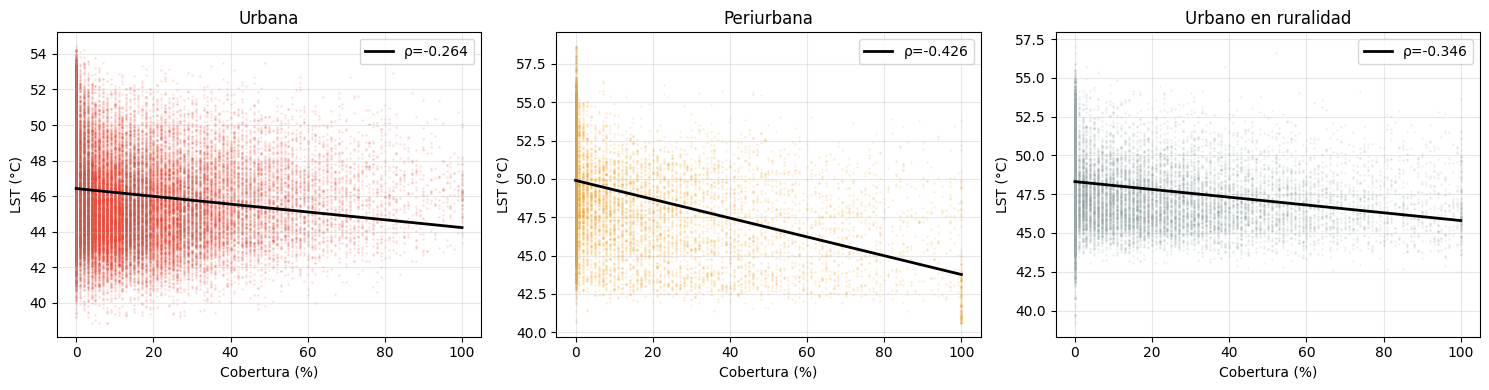

In [26]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
canopy_flat = canopy_coverage_xr.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))
    lst_class = lst_flat[mask]
    canopy_class = canopy_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(canopy_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(canopy_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_canopy': canopy_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Cobertura Arbórea - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(canopy_flat))
    canopy = canopy_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        canopy,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([canopy.min(), canopy.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Cobertura (%)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### LST by distance to water by populated area

In [27]:
wfs_url = "https://ide.pergamino.gob.ar:8443/geoserver/wfs"
layer_name = "publico:cursos_de_agua"

# Build GetFeature request
bbox = pergamino.to_crs("EPSG:4326").total_bounds

params = {
    "service": "WFS",
    "version": "2.0.0",
    "request": "GetFeature",
    "typename": layer_name,
    "outputFormat": "application/json",
    "srsname": "EPSG:4326",
    "bbox": f"{bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]},EPSG:4326",
}

response = requests.get(wfs_url, params=params)

if response.status_code == 200:
    cursos_agua_gdf = gpd.read_file(BytesIO(response.content))
    print(f"Loaded {len(cursos_agua_gdf)} watercourse features")
    print(f"CRS: {cursos_agua_gdf.crs}")

    # Clip to exact Pergamino boundary
    cursos_agua_gdf = cursos_agua_gdf.to_crs(pergamino.crs)

else:
    print(f"Error: {response.status_code}")
    print(response.text)

Loaded 430 watercourse features
CRS: EPSG:4326


Distance range: 0 - 12757 meters


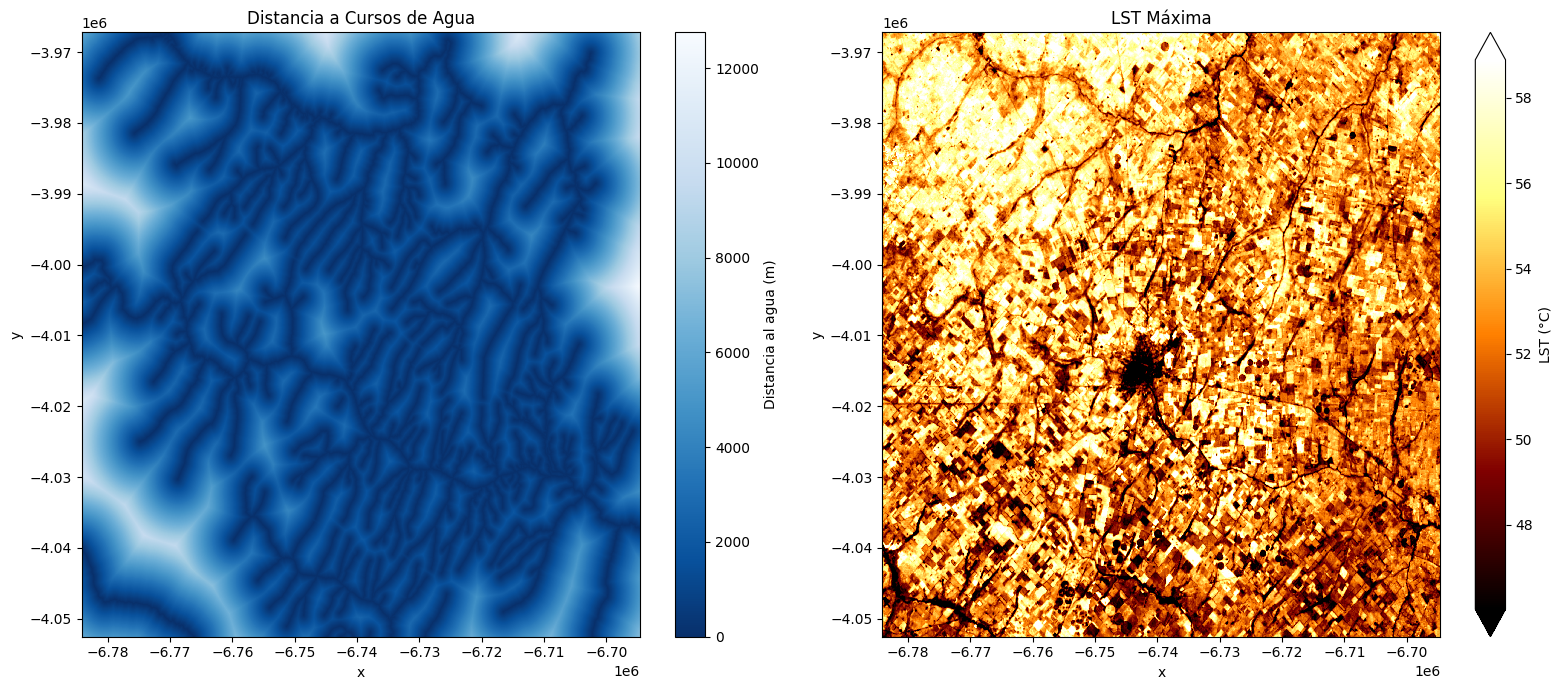

In [28]:
from rasterio import features
import numpy as np

# 1. Align watercourses to LST grid
cursos_agua_aligned = cursos_agua_gdf.to_crs(LST_max_computed.rio.crs)

# 2. Get transform and shape from LST raster
transform = LST_max_computed.rio.transform()
shape = LST_max_computed.shape

# 3. Rasterize water features directly
water_mask = features.rasterize(
    shapes=cursos_agua_aligned.geometry,
    out_shape=shape,
    transform=transform,
    fill=0,
    default_value=1,
    dtype="uint8",
)

# 4. Calculate distance transform
from scipy.ndimage import distance_transform_edt

distance_pixels = distance_transform_edt(~water_mask.astype(bool))

# Convert to meters
pixel_size = abs(float(LST_max_computed.rio.resolution()[0]))
distance_meters = distance_pixels * pixel_size

# 5. Create xarray with proper coords
distance_to_water = LST_max_computed.copy()
distance_to_water.values = distance_meters
distance_to_water.name = "distance_to_water"

print(
    f"Distance range: {distance_to_water.min().values:.0f} - {distance_to_water.max().values:.0f} meters"
)

# 6. Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

distance_to_water.plot(
    ax=ax1, cmap="Blues_r", cbar_kwargs={"label": "Distancia al agua (m)"}
)
ax1.set_title("Distancia a Cursos de Agua")

LST_max_computed.plot(
    ax=ax2, cmap="afmhot", robust=True, cbar_kwargs={"label": "LST (°C)"}
)
ax2.set_title("LST Máxima")

plt.tight_layout()
plt.show()


Relación Distancia al Agua - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho      p_value     slope  intercept  r_squared  mean_distance  mean_lst
             urbana     42239      0.281545 0.000000e+00  0.001001  45.004061   0.092419    1092.288722 46.097038
         periurbana     17024      0.384851 0.000000e+00  0.001353  47.664929   0.155751    1216.539712 49.311142
urbano en ruralidad     17418     -0.041872 3.235016e-08 -0.000179  48.143665   0.010205    1510.866101 47.873035


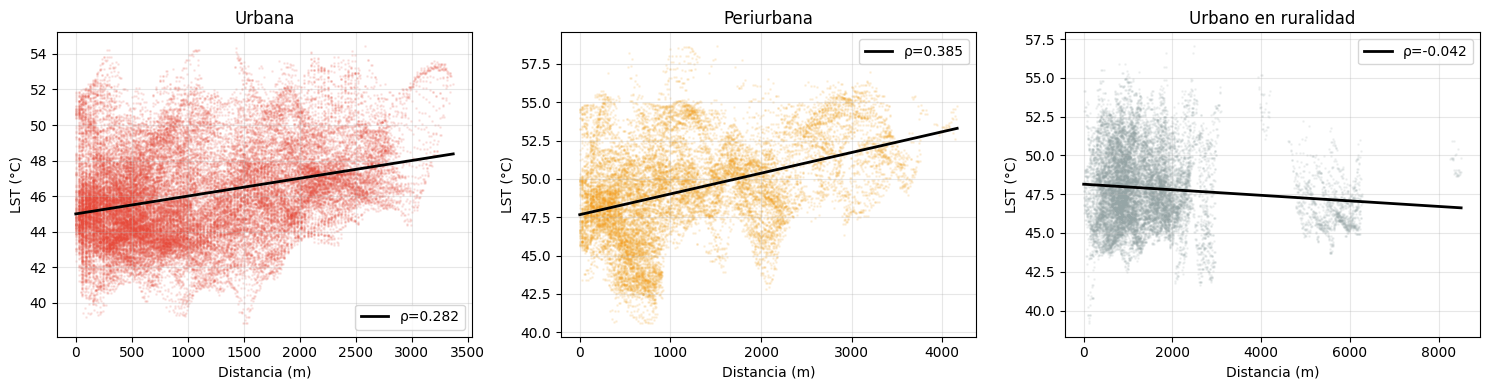

In [29]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(distance_flat))
    lst_class = lst_flat[mask]
    distance_class = distance_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(distance_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(distance_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_distance': distance_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Distancia al Agua - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(distance_flat))
    distance = distance_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        distance,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([distance.min(), distance.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Distancia (m)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### LST by building volume by type of area

In [30]:
import math
import geopandas as gpd
import os

import matplotlib.pyplot as plt

import geopandas as gpd


import pandas as pd


WEB_MERCATOR_CRS = "EPSG:3857"

# Your existing AOI geometry
# pergamino = gpd.read_file("pergamino.geojson")  # Example if not already loaded
CRS_WGS84 = "EPSG:4326"

# Output file
EDIFICACIONES_RUTA = "edificaciones_pergamino_gba.parquet"

# 1️⃣ Compute bounding box in WGS84
aoi_bounds = pergamino.to_crs(CRS_WGS84).total_bounds  # [xmin, ymin, xmax, ymax]
xmin, ymin, xmax, ymax = aoi_bounds
print(f"Caja delimitadora de Pergamino: {aoi_bounds}")


# 2️⃣ Compute overlapping 5°×5° tiles
def tile_name(lon_min, lat_min):
    """Return a tile filename component given SW corner (lon_min, lat_min)."""
    ew = "e" if lon_min >= 0 else "w"
    ns = "n" if lat_min >= 0 else "s"
    lon_tag = f"{abs(int(lon_min)):03d}"
    lat_tag = f"{abs(int(lat_min)):02d}"
    return ew + lon_tag + "_" + ns + lat_tag


# Compute all overlapping 5° grid indices
lon_starts = range(
    int(math.floor(xmin / 5.0)) * 5, int(math.ceil(xmax / 5.0)) * 5 + 5, 5
)
lat_starts = range(
    int(math.floor(ymin / 5.0)) * 5, int(math.ceil(ymax / 5.0)) * 5 + 5, 5
)

tiles = []
for lon0 in lon_starts:
    for lat0 in lat_starts:
        lon1 = lon0 + 5
        lat1 = lat0 + 5
        name = f"{tile_name(lon0, lat1)}_{tile_name(lon1, lat0)}.parquet"
        tiles.append(name)

print("Posibles tiles a usar:")
for t in tiles:
    print("  ", t)

# 3️⃣ Base URL for dataset
BASE_URL = "https://data.source.coop/tge-labs/globalbuildingatlas-lod1/"
urls = [BASE_URL + t for t in tiles]

# 4️⃣ Connect to DuckDB
con = duckdb.connect()
for cmd in [
    "INSTALL spatial",
    "LOAD spatial",
    "INSTALL httpfs",
    "LOAD httpfs",
    "SET s3_url_style='path'",
    "SET s3_use_ssl=true",
]:
    con.execute(cmd)

# 5️⃣ Query & filter each tile by AOI bbox
if os.path.exists(EDIFICACIONES_RUTA):
    print("Cargando edificaciones existentes...")
    edificaciones = gpd.read_parquet(EDIFICACIONES_RUTA)
else:
    print("Descargando y filtrando datos de Global Building Atlas (LOD1)...")

    aoi_filter = f"""
    bbox.xmax >= {xmin} AND bbox.xmin <= {xmax} AND
    bbox.ymax >= {ymin} AND bbox.ymin <= {ymax}
    """

    # Combine all matching tiles
    query = f"""
    COPY (
        SELECT id, height, geometry
        FROM read_parquet({urls}, filename=true)
        WHERE {aoi_filter}
    ) TO '{EDIFICACIONES_RUTA}' (FORMAT PARQUET);
    """

    con.execute(query)
    print("Datos guardados localmente como Parquet.")

    # Load into GeoDataFrame
    df = gpd.read_parquet(EDIFICACIONES_RUTA)
    # The geometry column is already shapely Polygon objects
    edificaciones = gpd.GeoDataFrame(df, geometry="geometry", crs=CRS_WGS84)


# 6️⃣ Clip to AOI
edificaciones = edificaciones.to_crs(USE_CRS)
edificaciones = edificaciones[edificaciones.intersects(pergamino.geometry.iloc[0])]
print(f"Total de edificaciones dentro de Pergamino: {len(edificaciones)}")

Caja delimitadora de Pergamino: [-60.942796   -34.17645991 -60.138771   -33.54020044]
Posibles tiles a usar:
   w065_s30_w060_s35.parquet
   w065_s25_w060_s30.parquet
   w060_s30_w055_s35.parquet
   w060_s25_w055_s30.parquet
Cargando edificaciones existentes...
Total de edificaciones dentro de Pergamino: 116088


Pixel size: 24.88 × 24.88 m
Pixel area: 619.22 m²
Volume density range: 0.00 - 227.59 m³/m²
Total pixels: 8,579,124
Non-zero pixels: 14,797
Range: 0.00 - 227.59 m³/m²


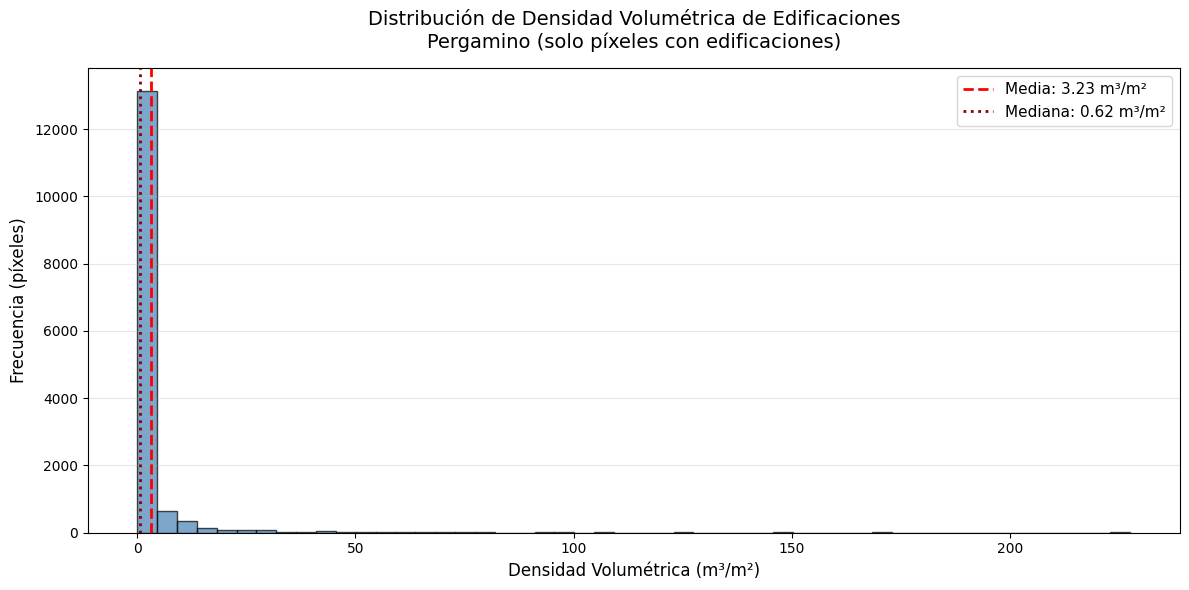


Estadísticas:
  Media: 3.23 m³/m²
  Mediana: 0.62 m³/m²
  Desv. Est.: 12.84 m³/m²
  Percentil 95: 12.37 m³/m²


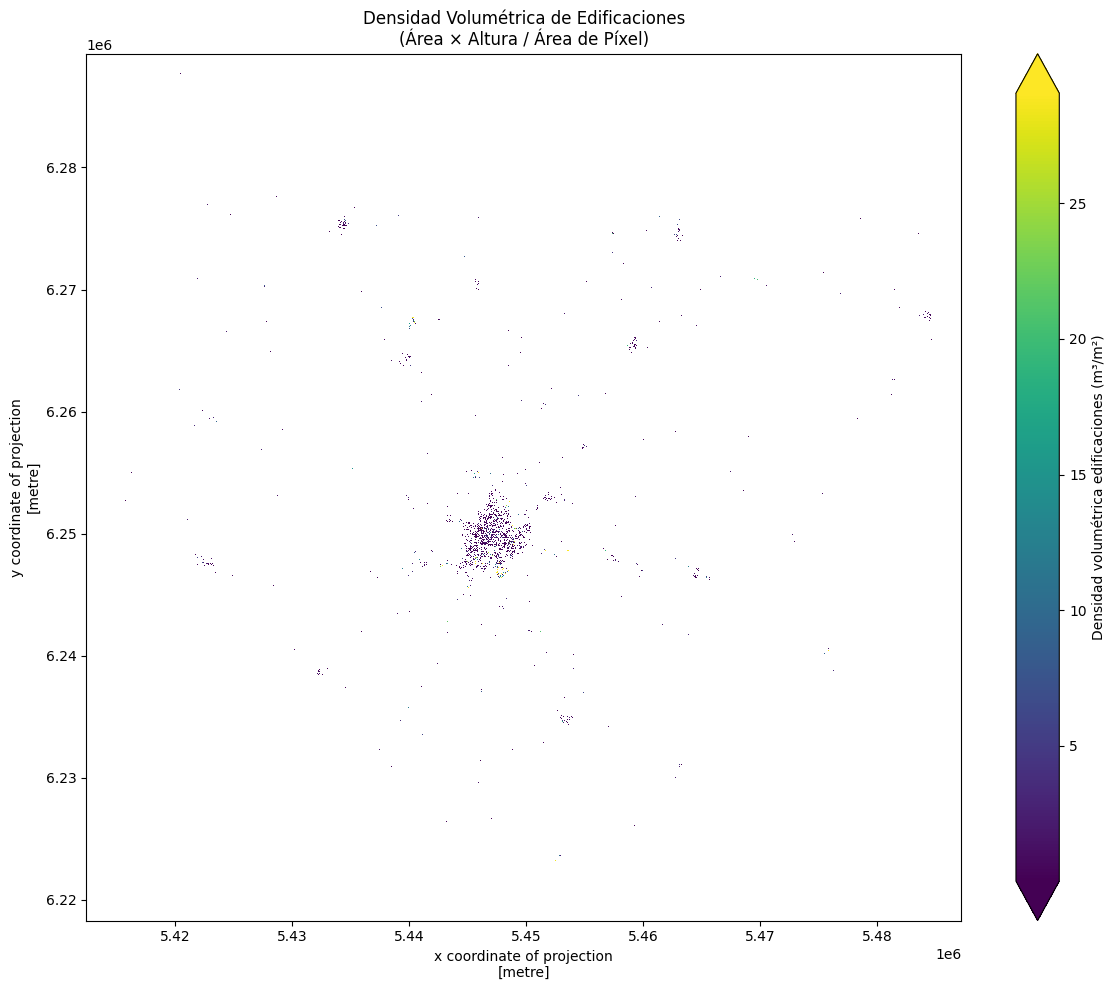

In [31]:
from geocube.api.core import make_geocube

# 1. Calculate building volume (footprint area × height)
edificaciones["area"] = edificaciones.geometry.area  # in CRS units (m²)
edificaciones["volume"] = edificaciones["area"] * edificaciones["height"].fillna(0)

# 1. Reproject template to match buildings CRS (meters)
template_projected = LST_max_computed.rio.reproject("EPSG:5347")

# 2. Recalculate areas in proper CRS
edificaciones_aligned = edificaciones.to_crs("EPSG:5347")  # Should already be there
edificaciones_aligned["area"] = edificaciones_aligned.geometry.area
edificaciones_aligned["volume"] = edificaciones_aligned["area"] * edificaciones_aligned[
    "height"
].fillna(0)

# 3. Rasterize using projected template
building_cube = make_geocube(
    vector_data=edificaciones_aligned,
    measurements=["volume"],
    like=template_projected,
    fill=0,
)

# 4. Calculate pixel area in meters (now correct)
pixel_width = abs(float(template_projected.rio.resolution()[0]))
pixel_height = abs(float(template_projected.rio.resolution()[1]))
pixel_area = pixel_width * pixel_height

print(f"Pixel size: {pixel_width:.2f} × {pixel_height:.2f} m")
print(f"Pixel area: {pixel_area:.2f} m²")

# 5. Normalize properly
volume_density = building_cube["volume"] / pixel_area

print(
    f"Volume density range: {float(volume_density.min()):.2f} - {float(volume_density.max()):.2f} m³/m²"
)

# Get non-zero values for histogram
values = volume_density.values.flatten()
values_nonzero = values[values > 0]

print(f"Total pixels: {len(values):,}")
print(f"Non-zero pixels: {len(values_nonzero):,}")
print(f"Range: {values_nonzero.min():.2f} - {values_nonzero.max():.2f} m³/m²")

# Histogram
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(values_nonzero, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
ax.axvline(
    values_nonzero.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Media: {values_nonzero.mean():.2f} m³/m²",
)
ax.axvline(
    np.median(values_nonzero),
    color="darkred",
    linestyle=":",
    linewidth=2,
    label=f"Mediana: {np.median(values_nonzero):.2f} m³/m²",
)

ax.set_xlabel("Densidad Volumétrica (m³/m²)", fontsize=12)
ax.set_ylabel("Frecuencia (píxeles)", fontsize=12)
ax.set_title(
    "Distribución de Densidad Volumétrica de Edificaciones\nPergamino (solo píxeles con edificaciones)",
    fontsize=14,
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Additional stats
print("\nEstadísticas:")
print(f"  Media: {values_nonzero.mean():.2f} m³/m²")
print(f"  Mediana: {np.median(values_nonzero):.2f} m³/m²")
print(f"  Desv. Est.: {values_nonzero.std():.2f} m³/m²")
print(f"  Percentil 95: {np.percentile(values_nonzero, 95):.2f} m³/m²")

# Mask out 0 values for plotting
volume_density_masked = volume_density.where(volume_density > 0)

# Optional: Visualize
fig, ax = plt.subplots(figsize=(12, 10))
volume_density_masked.plot(
    ax=ax,
    cmap="viridis",
    cbar_kwargs={"label": "Densidad volumétrica edificaciones (m³/m²)"},
    robust=True,
)
ax.set_title("Densidad Volumétrica de Edificaciones\n(Área × Altura / Área de Píxel)")
plt.tight_layout()
plt.show()


Relación Densidad Volumétrica - LST por Tipo de Área:
      clasificacion  n_pixels  spearman_rho      p_value    slope  intercept  r_squared  mean_density  mean_lst
             urbana      9639     -0.072539 1.002206e-12 0.035648  44.916545   0.012083      1.924513 44.985149
         periurbana      1126     -0.115310 1.053249e-04 0.000453  47.874733   0.000029     13.279398 47.880749
urbano en ruralidad      1902      0.136128 2.512177e-09 0.029127  47.398619   0.018126      2.930734 47.483982


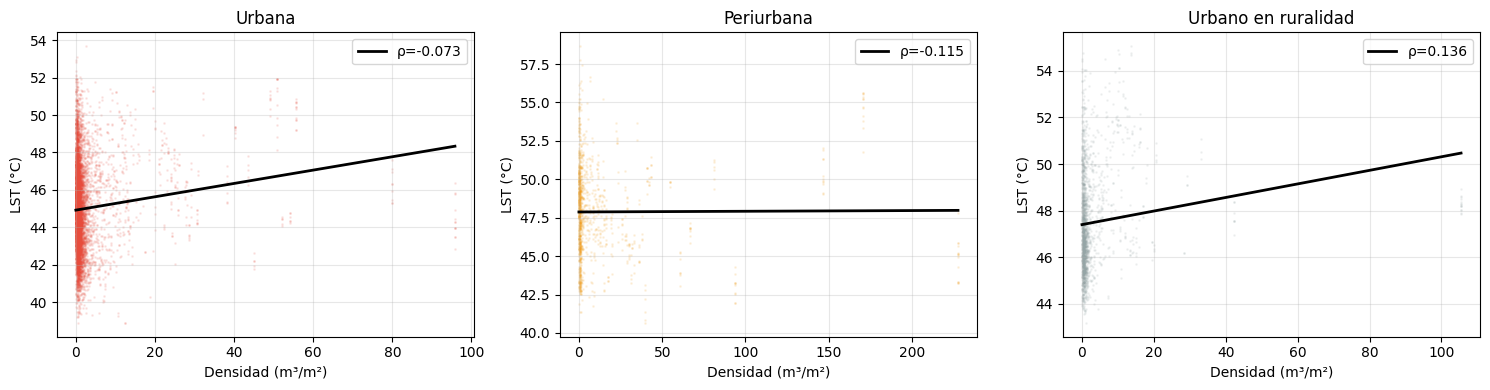

In [32]:
from rasterio import features
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Flatten rasters
volume_density_aligned = volume_density.rio.reproject_match(LST_max_computed)
density_flat = volume_density_aligned.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Calculate statistics by urban type
results = []
for clasificacion, code in clasificacion_to_code.items():
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(density_flat)) & (density_flat > 0)
    lst_class = lst_flat[mask]
    density_class = density_flat[mask]
    
    if len(lst_class) > 1:
        rho, p_value = stats.spearmanr(density_class, lst_class)
        slope, intercept, r_value, _, _ = stats.linregress(density_class, lst_class)
        
        results.append({
            'clasificacion': clasificacion,
            'n_pixels': len(lst_class),
            'spearman_rho': rho,
            'p_value': p_value,
            'slope': slope,
            'intercept': intercept,
            'r_squared': r_value**2,
            'mean_density': density_class.mean(),
            'mean_lst': lst_class.mean()
        })

df_results = pd.DataFrame(results)
print("\nRelación Densidad Volumétrica - LST por Tipo de Área:")
print(df_results.to_string(index=False))

# Visualization with scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = {'urbana': '#e74c3c', 'periurbana': '#f39c12', 'urbano en ruralidad': '#95a5a6'}

for idx, (clasificacion, code) in enumerate(clasificacion_to_code.items()):
    mask = (clasificacion_flat == code) & (~np.isnan(lst_flat)) & (~np.isnan(density_flat)) & (density_flat > 0)
    density = density_flat[mask]
    lst = lst_flat[mask]
    
    axes[idx].scatter(
        density,
        lst,
        s=1,
        alpha=0.1,
        color=colors[clasificacion],
        rasterized=True
    )
    
    row = df_results[df_results['clasificacion'] == clasificacion].iloc[0]
    x_line = np.array([density.min(), density.max()])
    y_line = row['slope'] * x_line + row['intercept']
    axes[idx].plot(x_line, y_line, 'k-', linewidth=2, 
                   label=f"ρ={row['spearman_rho']:.3f}")
    
    axes[idx].set_title(clasificacion.capitalize())
    axes[idx].set_xlabel("Densidad (m³/m²)")
    axes[idx].set_ylabel("LST (°C)")
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Explanatory model

In [34]:
from scipy import stats as sp_stats
from scipy.ndimage import gaussian_filter
from rasterio import features

# Rasterize urban classifications to match LST grid
aglomerados_aligned = aglomerados_urbanos.to_crs(LST_max_computed.rio.crs)

clasificacion_to_code = {
    'urbana': 1,
    'periurbana': 2,
    'urbano en ruralidad': 3
}

aglomerados_aligned['code'] = aglomerados_aligned['clasificacion'].map(clasificacion_to_code)

clasificacion_raster = features.rasterize(
    shapes=((geom, value) for geom, value in zip(aglomerados_aligned.geometry, aglomerados_aligned['code'])),
    out_shape=LST_max_computed.shape,
    transform=LST_max_computed.rio.transform(),
    fill=0,
    dtype='uint8'
)

# Prepare data using urban classification zones
canopy_flat = canopy_coverage_xr.values.flatten()
density_flat = volume_density_aligned.values.flatten()
distance_flat = distance_to_water.values.flatten()
lst_flat = LST_max_computed.values.flatten()
clasificacion_flat = clasificacion_raster.flatten()

# Filter for any pixel within urban classification zones
urban_mask = (
    (clasificacion_flat > 0)
    & (~np.isnan(lst_flat))
    & (~np.isnan(canopy_flat))
    & (~np.isnan(density_flat))
    & (~np.isnan(distance_flat))
)

df_urban = pd.DataFrame({
    "LST": lst_flat[urban_mask],
    "Canopy_Coverage": canopy_flat[urban_mask],
    "Building_Density": density_flat[urban_mask],
    "Distance_Water": distance_flat[urban_mask],
})

print(f"Urban pixels for modeling: {len(df_urban):,}\n")

# Spatial lag model
sigma = 7.0
print(f"Final Model (sigma={sigma}, ~420m radius)\n")

# Smooth predictors
canopy_smoothed = gaussian_filter(canopy_coverage_xr.values, sigma=sigma)
density_smoothed = gaussian_filter(np.log10(volume_density_aligned.values + 0.01), sigma=sigma)
distance_smoothed = gaussian_filter(distance_to_water.values, sigma=sigma)

df_urban["Canopy_Lag"] = canopy_smoothed.flatten()[urban_mask]
df_urban["Density_Lag"] = density_smoothed.flatten()[urban_mask]
df_urban["Distance_Lag"] = distance_smoothed.flatten()[urban_mask]

# Build model
X_spatial = np.column_stack([
    np.ones(len(df_urban)),
    df_urban["Canopy_Coverage"],
    np.log10(df_urban["Building_Density"] + 0.01),
    df_urban["Distance_Water"],
    df_urban["Canopy_Lag"],
    df_urban["Density_Lag"],
    df_urban["Distance_Lag"],
])
y = df_urban["LST"].values

# Fit model
beta = np.linalg.lstsq(X_spatial, y, rcond=None)[0]
y_pred = X_spatial @ beta

# Calculate standard errors and p-values
n = len(y)
k = X_spatial.shape[1] - 1
residuals = y - y_pred
mse = np.sum(residuals**2) / (n - k - 1)

var_covar = mse * np.linalg.inv(X_spatial.T @ X_spatial)
std_errors = np.sqrt(np.diag(var_covar))

t_stats = beta / std_errors
p_values = 2 * (1 - sp_stats.t.cdf(np.abs(t_stats), df=n - k - 1))

ci_95 = 1.96 * std_errors

# Print results
feature_names = [
    "Intercept",
    "Canopy (%)",
    "Building (log)",
    "Distance (m)",
    "Neighbor Canopy (%)",
    "Neighbor Building (log)",
    "Neighbor Distance (m)",
]

print("=" * 80)
print(f"{'Variable':<28s} | {'Coef':>8s} | {'Std Err':>8s} | {'t-stat':>8s} | {'p-value':>10s} | {'Sig':>4s}")
print("=" * 80)

for i, (name, coef, se, t, p) in enumerate(zip(feature_names, beta, std_errors, t_stats, p_values)):
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
    print(f"{name:<28s} | {coef:+8.4f} | {se:8.4f} | {t:+8.2f} | {p:10.2e} | {sig:>4s}")

print("=" * 80)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05\n")

# Practical interpretations
print("=" * 80)
print("PRACTICAL EFFECTS (holding other variables constant)")
print("=" * 80)

print("\nLocal Effects (your pixel):")
print(f"  +10% canopy          → {beta[1] * 10:+.2f}°C")
print(f"  10× building density → {beta[2]:+.2f}°C (log scale)")
print(f"  +1000m from water    → {beta[3] * 1000:+.2f}°C")

print("\nNeighborhood Effects (within 420m):")
print(f"  +10% canopy          → {beta[4] * 10:+.2f}°C")
print(f"  10× building density → {beta[5]:+.2f}°C")
print(f"  +1000m from water    → {beta[6] * 1000:+.2f}°C")

print("\nComposite Scenario - Adding Trees to Neighborhood:")
print("  Increase neighborhood canopy from 10% → 30%")
print(f"  Effect: {beta[4] * 20:+.2f}°C cooling")
print("  (= planting street trees across 4-5 blocks)")

# R² info
r2 = 1 - (np.sum(residuals**2) / np.sum((y - y.mean()) ** 2))
print("\nModel Performance:")
print(f"  R² = {r2:.4f} ({r2 * 100:.1f}% variance explained)")
print(f"  RMSE = {np.sqrt(mse):.2f}°C")

Urban pixels for modeling: 76,681

Final Model (sigma=7.0, ~420m radius)

Variable                     |     Coef |  Std Err |   t-stat |    p-value |  Sig
Intercept                    | +36.9693 |   0.0635 |  +581.84 |   0.00e+00 |  ***
Canopy (%)                   |  -0.0120 |   0.0004 |   -31.04 |   0.00e+00 |  ***
Building (log)               |  -0.1527 |   0.0102 |   -14.93 |   0.00e+00 |  ***
Distance (m)                 |  +0.0019 |   0.0002 |   +12.06 |   0.00e+00 |  ***
Neighbor Canopy (%)          |  -0.1552 |   0.0012 |  -134.62 |   0.00e+00 |  ***
Neighbor Building (log)      |  -6.6684 |   0.0355 |  -187.90 |   0.00e+00 |  ***
Neighbor Distance (m)        |  -0.0015 |   0.0002 |    -9.29 |   0.00e+00 |  ***
Significance: *** p<0.001, ** p<0.01, * p<0.05

PRACTICAL EFFECTS (holding other variables constant)

Local Effects (your pixel):
  +10% canopy          → -0.12°C
  10× building density → -0.15°C (log scale)
  +1000m from water    → +1.94°C

Neighborhood Effects (within

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import shap
import pandas as pd
import numpy as np

# ============================================================================
# STEP 1: Prepare land cover data
# ============================================================================

# Align land cover to LST grid
suelo_aligned = suelo_2022.rio.reproject_match(LST_max_computed)

# Create one-hot encoded land cover features
land_cover_flat = suelo_aligned.values.flatten()

# Define major land cover classes (group some of the 16 categories)
# You can adjust these groupings based on what makes sense
lc_classes = {
    'lc_woody_closed': [3],  # Leñosa cerrada
    'lc_woody_open': [4, 45],  # Leñosa abierta + dispersa
    'lc_grassland': [12, 63],  # Pastizal + Estepa
    'lc_pasture': [15],  # Pastura
    'lc_agriculture': [18, 36],  # Agricultura + Cultivo arbustivo
    'lc_forest_plantation': [9],  # Plantación forestal
    'lc_wetland': [6, 11],  # Leñosa inundable + Vegetación no leñosa inundable
    'lc_bare': [22],  # Área sin vegetación
    'lc_water': [33],  # Río, lago u océano
}

# Create binary columns for each land cover class
lc_features = {}
for lc_name, lc_ids in lc_classes.items():
    lc_mask = np.isin(land_cover_flat, lc_ids)
    lc_features[lc_name] = lc_mask.astype(int)

In [40]:
# ============================================================================
# STEP 2: Prepare all features for modeling
# ============================================================================

# Get settlement type (clasificacion)
clasificacion_flat = clasificacion_raster.flatten()

# Create urban classification one-hot encoded
clasificacion_features = {
    'area_urbana': (clasificacion_flat == 1).astype(int),
    'area_periurbana': (clasificacion_flat == 2).astype(int),
    'area_rural': (clasificacion_flat == 3).astype(int),
}

# Combine everything into a dataframe
df_model = pd.DataFrame({
    "LST": lst_flat[urban_mask],
    "Canopy_Coverage": canopy_flat[urban_mask],
    "Building_Density_Log": np.log10(density_flat[urban_mask] + 0.01),
    "Distance_Water": distance_flat[urban_mask],
    "Canopy_Lag": canopy_smoothed.flatten()[urban_mask],
    "Building_Density_Lag": density_smoothed.flatten()[urban_mask],
    # Drop one distance variable to avoid multicollinearity issues
    # Keep neighborhood distance since it had stronger effect
    # "Distance_Lag": distance_smoothed.flatten()[urban_mask],
})

# Add land cover one-hot features
for lc_name, lc_array in lc_features.items():
    df_model[lc_name] = lc_array[urban_mask]

# Add settlement type one-hot features (drop one as reference - urbana)
df_model['area_periurbana'] = clasificacion_features['area_periurbana'][urban_mask]
df_model['area_rural'] = clasificacion_features['area_rural'][urban_mask]

# Also add coordinates for spatial blocking
coords = np.argwhere(~np.isnan(LST_max_computed.values))
x_coords = coords[:, 1][urban_mask]
y_coords = coords[:, 0][urban_mask]
df_model['x_coord'] = x_coords
df_model['y_coord'] = y_coords

print(f"Total features: {df_model.shape[1] - 3}")  # -3 for LST, x_coord, y_coord
print(f"Samples: {len(df_model):,}\n")

Total features: 16
Samples: 76,681



In [46]:
# ============================================================================
# STEP 3: Prepare for modeling with spatial cross-validation
# ============================================================================

# Create spatial blocks for cross-validation (e.g., ~5km grid cells)
# Adjust block_size based on your pixel resolution
pixel_resolution = 30  # meters (adjust to your actual resolution)
block_size_pixels = int(500 / pixel_resolution)  # ~5km blocks

df_model['spatial_block'] = (
    (df_model['x_coord'] // block_size_pixels).astype(str) + '_' + 
    (df_model['y_coord'] // block_size_pixels).astype(str)
)

# Prepare X and y
feature_cols = [col for col in df_model.columns 
                if col not in ['LST', 'x_coord', 'y_coord', 'spatial_block']]
X = df_model[feature_cols].values
y = df_model['LST'].values
spatial_blocks = df_model['spatial_block'].values

print("Features included:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")
print()

Features included:
  1. Canopy_Coverage
  2. Building_Density_Log
  3. Distance_Water
  4. Canopy_Lag
  5. Building_Density_Lag
  6. lc_woody_closed
  7. lc_woody_open
  8. lc_grassland
  9. lc_pasture
  10. lc_agriculture
  11. lc_forest_plantation
  12. lc_wetland
  13. lc_bare
  14. lc_water
  15. area_periurbana
  16. area_rural



In [47]:
# ============================================================================
# STEP 4: Spatial Cross-Validation
# ============================================================================

print("Running spatial cross-validation...\n")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

# Spatial GroupKFold
gkf = GroupKFold(n_splits=15)

cv_r2_scores = []
cv_rmse_scores = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=spatial_blocks), 1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    cv_r2_scores.append(r2)
    cv_rmse_scores.append(rmse)
    
    print(f"Fold {fold}: R² = {r2:.4f}, RMSE = {rmse:.2f}°C")

print(f"\nCross-validation Results:")
print(f"  Mean R² = {np.mean(cv_r2_scores):.4f} (±{np.std(cv_r2_scores):.4f})")
print(f"  Mean RMSE = {np.mean(cv_rmse_scores):.2f}°C (±{np.std(cv_rmse_scores):.2f}°C)")

Running spatial cross-validation...

Fold 1: R² = 0.6160, RMSE = 1.77°C
Fold 2: R² = 0.6704, RMSE = 1.70°C
Fold 3: R² = 0.6841, RMSE = 1.71°C
Fold 4: R² = 0.6989, RMSE = 1.48°C
Fold 5: R² = 0.5857, RMSE = 1.78°C
Fold 6: R² = 0.6620, RMSE = 1.64°C
Fold 7: R² = 0.7128, RMSE = 1.44°C
Fold 8: R² = 0.6443, RMSE = 1.48°C
Fold 9: R² = 0.6888, RMSE = 1.74°C
Fold 10: R² = 0.6778, RMSE = 1.63°C
Fold 11: R² = 0.7177, RMSE = 1.78°C
Fold 12: R² = 0.7934, RMSE = 1.55°C
Fold 13: R² = 0.7678, RMSE = 1.45°C
Fold 14: R² = 0.7322, RMSE = 1.62°C
Fold 15: R² = 0.7285, RMSE = 1.74°C

Cross-validation Results:
  Mean R² = 0.6920 (±0.0523)
  Mean RMSE = 1.63°C (±0.12°C)


In [49]:
# Check total spatial extent
print(f"X range: {df_model['x_coord'].min()} to {df_model['x_coord'].max()}")
print(f"Y range: {df_model['y_coord'].min()} to {df_model['y_coord'].max()}")
print(f"Number of 500m blocks: {df_model['spatial_block'].nunique()}")

X range: 347 to 2894
Y range: 198 to 2474
Number of 500m blocks: 577


In [50]:
# ============================================================================
# STEP 5: Train final model on all data
# ============================================================================

print("\nTraining final model on all data...\n")
rf_final = RandomForestRegressor(
    n_estimators=200,  # More trees for final model
    max_depth=20,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42
)

rf_final.fit(X, y)
y_pred_final = rf_final.predict(X)

r2_final = r2_score(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))

print(f"Final Model Performance:")
print(f"  R² = {r2_final:.4f}")
print(f"  RMSE = {rmse_final:.2f}°C\n")


Training final model on all data...

Final Model Performance:
  R² = 0.8064
  RMSE = 1.31°C



In [51]:
# ============================================================================
# STEP 6: Feature Importance
# ============================================================================

print("=" * 80)
print("FEATURE IMPORTANCE (Top 15)")
print("=" * 80)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:<30s} {row['importance']:>8.4f}")

FEATURE IMPORTANCE (Top 15)
Canopy_Lag                       0.3019
Building_Density_Lag             0.2840
Distance_Water                   0.1204
Canopy_Coverage                  0.1033
lc_bare                          0.0608
area_periurbana                  0.0426
lc_grassland                     0.0278
area_rural                       0.0174
Building_Density_Log             0.0138
lc_forest_plantation             0.0109
lc_pasture                       0.0100
lc_agriculture                   0.0027
lc_water                         0.0026
lc_woody_closed                  0.0016
lc_woody_open                    0.0002




Computing SHAP values (this may take a few minutes)...

OVERALL SHAP VALUE STATISTICS
Feature                        | Mean |SHAP|  | Mean SHAP  | Std     
------------------------------------------------------------------------------------------
Canopy_Lag                     |       0.8560 |    +0.0325 |   1.0243
Building_Density_Lag           |       0.7564 |    +0.0055 |   0.9331
Distance_Water                 |       0.4717 |    +0.0162 |   0.5654
Canopy_Coverage                |       0.4244 |    -0.0014 |   0.4565
lc_bare                        |       0.2900 |    -0.0090 |   0.3235
lc_grassland                   |       0.1588 |    -0.0149 |   0.1743
area_periurbana                |       0.1533 |    -0.0275 |   0.2055
area_rural                     |       0.0838 |    +0.0126 |   0.1201
Building_Density_Log           |       0.0812 |    -0.0002 |   0.1171
lc_pasture                     |       0.0535 |    -0.0111 |   0.0904
lc_forest_plantation           |       0.0266 |    

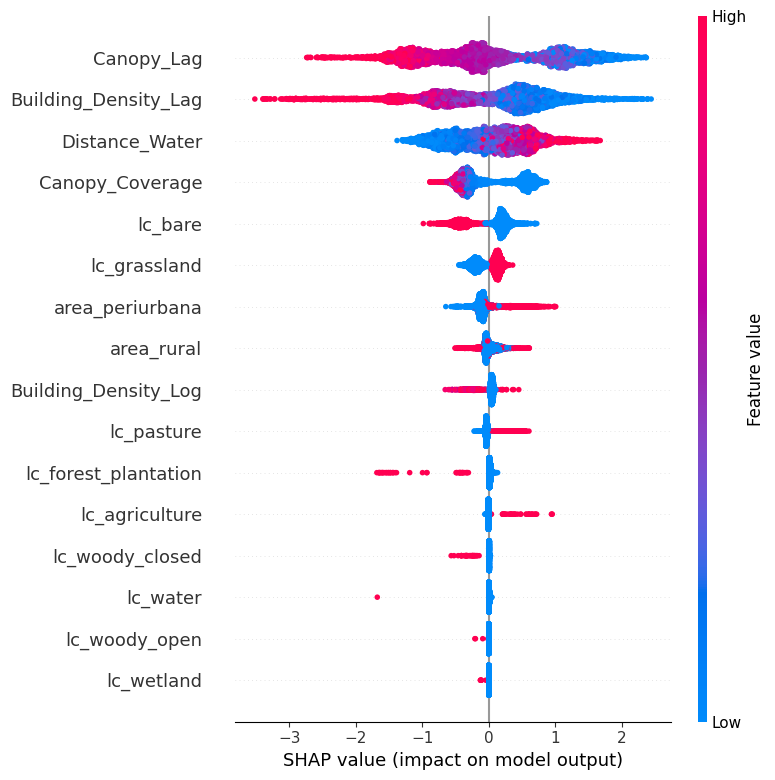

In [52]:
# ============================================================================
# STEP 7: SHAP Values for Interpretation
# ============================================================================
print("\n\nComputing SHAP values (this may take a few minutes)...\n")

# Use a sample for SHAP to speed up computation (adjust sample size as needed)
sample_size = min(5000, len(X))
sample_idx = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[sample_idx]

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_final)
shap_values = explainer.shap_values(X_sample)

# Calculate mean absolute SHAP values for overall importance
shap_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Mean_|SHAP|': np.abs(shap_values).mean(axis=0),
    'Mean_SHAP': shap_values.mean(axis=0),
    'Std_SHAP': shap_values.std(axis=0),
    'Max_SHAP': shap_values.max(axis=0),
    'Min_SHAP': shap_values.min(axis=0)
}).sort_values('Mean_|SHAP|', ascending=False)

print("=" * 90)
print("OVERALL SHAP VALUE STATISTICS")
print("=" * 90)
print(f"{'Feature':<30s} | {'Mean |SHAP|':<12s} | {'Mean SHAP':<10s} | {'Std':<8s}")
print("-" * 90)
for _, row in shap_importance.iterrows():
    print(f"{row['Feature']:<30s} | {row['Mean_|SHAP|']:>12.4f} | {row['Mean_SHAP']:>+10.4f} | {row['Std_SHAP']:>8.4f}")
print("=" * 90)
print()

# Summary plot
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False)
plt.tight_layout()
plt.savefig('shap_summary_all.png', dpi=300, bbox_inches='tight')
plt.show()


Generating SHAP plots by settlement type...

SHAP STATISTICS - URBANA (n=2,000)
Feature                        | Mean |SHAP|  | Mean SHAP  | Std     
------------------------------------------------------------------------------------------
Building_Density_Lag           |       0.8777 |    -0.4899 |   0.9723
Canopy_Lag                     |       0.6675 |    -0.2725 |   0.7816
Distance_Water                 |       0.4506 |    -0.0204 |   0.5290
Canopy_Coverage                |       0.4129 |    -0.0628 |   0.4406
lc_bare                        |       0.3792 |    -0.1392 |   0.3761
lc_grassland                   |       0.1796 |    -0.0745 |   0.1807
area_periurbana                |       0.1137 |    -0.1075 |   0.0608
Building_Density_Log           |       0.0939 |    -0.0194 |   0.1314
area_rural                     |       0.0578 |    -0.0026 |   0.0798
lc_pasture                     |       0.0484 |    -0.0244 |   0.0752
lc_forest_plantation           |       0.0113 |    +0.0109

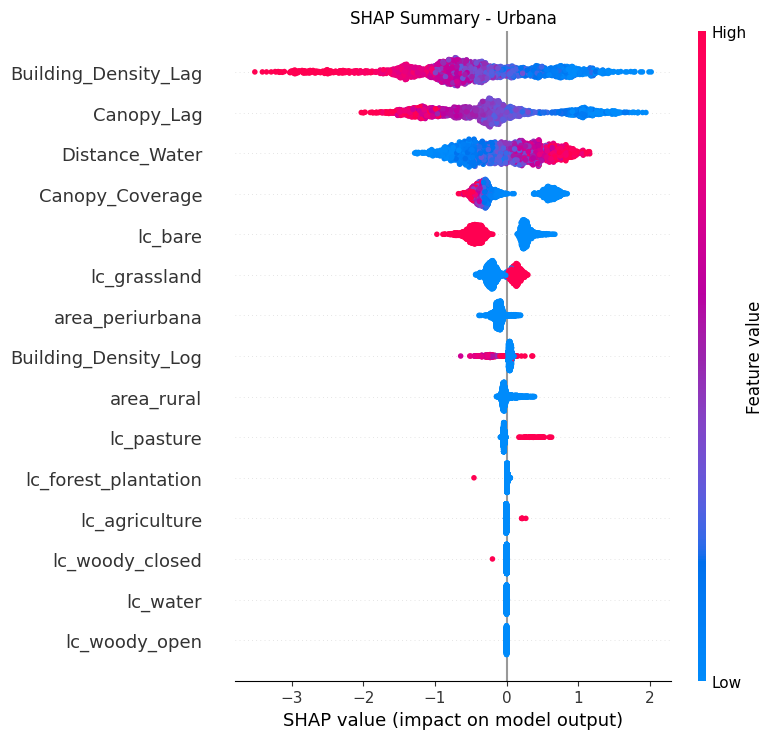

SHAP STATISTICS - PERIURBANA (n=2,000)
Feature                        | Mean |SHAP|  | Mean SHAP  | Std     
------------------------------------------------------------------------------------------
Canopy_Lag                     |       1.2497 |    +0.6909 |   1.1897
Building_Density_Lag           |       0.7797 |    +0.6657 |   0.6413
Distance_Water                 |       0.6314 |    -0.0330 |   0.7307
Canopy_Coverage                |       0.4874 |    +0.1902 |   0.4726
area_periurbana                |       0.2827 |    +0.2585 |   0.2449
lc_bare                        |       0.1800 |    +0.1179 |   0.1601
lc_grassland                   |       0.1484 |    +0.0572 |   0.1469
Building_Density_Log           |       0.0757 |    +0.0275 |   0.1091
area_rural                     |       0.0734 |    +0.0578 |   0.0687
lc_pasture                     |       0.0443 |    +0.0071 |   0.0784
lc_forest_plantation           |       0.0268 |    +0.0142 |   0.0655
lc_agriculture                

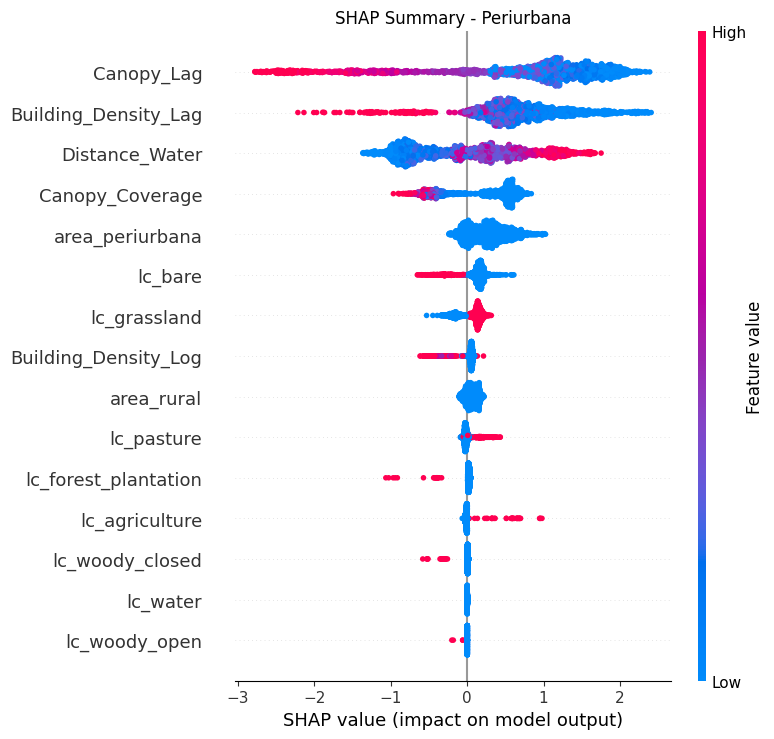

SHAP STATISTICS - URBANO EN RURALIDAD (n=2,000)
Feature                        | Mean |SHAP|  | Mean SHAP  | Std     
------------------------------------------------------------------------------------------
Canopy_Lag                     |       0.9555 |    +0.0062 |   1.0735
Building_Density_Lag           |       0.5378 |    +0.4642 |   0.3972
Canopy_Coverage                |       0.4196 |    -0.0091 |   0.4492
Distance_Water                 |       0.3501 |    +0.1249 |   0.4002
lc_bare                        |       0.1881 |    +0.1346 |   0.1440
area_rural                     |       0.1508 |    -0.0083 |   0.1962
area_periurbana                |       0.1236 |    -0.1193 |   0.1014
lc_grassland                   |       0.1175 |    +0.0459 |   0.1241
lc_pasture                     |       0.0687 |    -0.0006 |   0.1112
Building_Density_Log           |       0.0635 |    +0.0064 |   0.0967
lc_forest_plantation           |       0.0570 |    -0.0117 |   0.2250
lc_woody_closed      

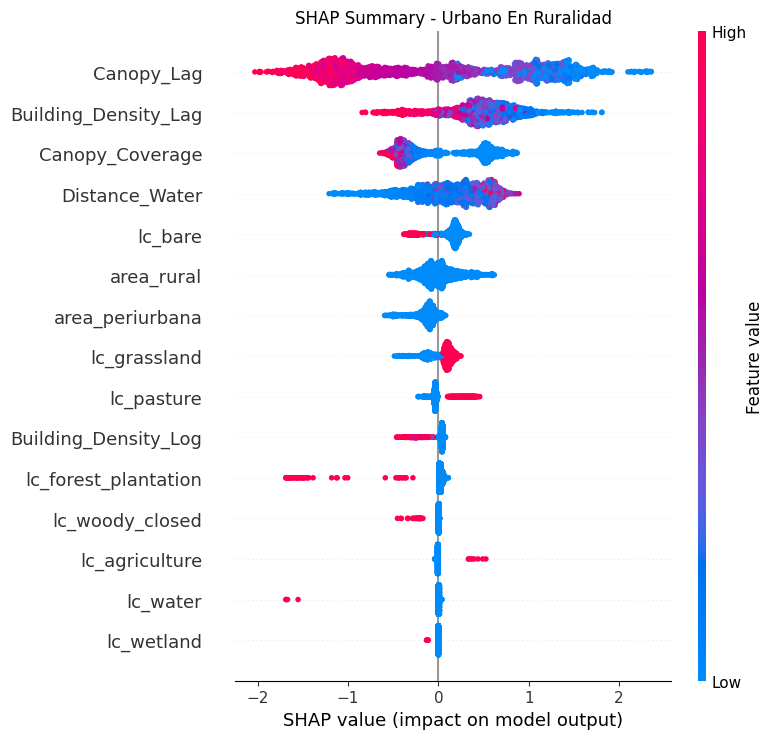

In [53]:
# ============================================================================
# STEP 8: SHAP Analysis by Settlement Type
# ============================================================================
print("\nGenerating SHAP plots by settlement type...\n")

# Store results for comparison
settlement_shap_results = {}

for area_code, area_name in [(1, 'urbana'), (2, 'periurbana'), (3, 'urbano en ruralidad')]:
    # Get indices for this settlement type
    area_mask = (clasificacion_flat[urban_mask] == area_code)
    area_indices = np.where(area_mask)[0]
    
    # Sample from this settlement type
    if len(area_indices) > 2000:
        area_sample_idx = np.random.choice(area_indices, 2000, replace=False)
    else:
        area_sample_idx = area_indices
    
    X_area = X[area_sample_idx]
    shap_area = explainer.shap_values(X_area)
    
    # Calculate SHAP statistics for this settlement type
    shap_area_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Mean_|SHAP|': np.abs(shap_area).mean(axis=0),
        'Mean_SHAP': shap_area.mean(axis=0),
        'Std_SHAP': shap_area.std(axis=0)
    }).sort_values('Mean_|SHAP|', ascending=False)
    
    settlement_shap_results[area_name] = shap_area_importance
    
    # Print statistics
    print("=" * 90)
    print(f"SHAP STATISTICS - {area_name.upper()} (n={len(area_sample_idx):,})")
    print("=" * 90)
    print(f"{'Feature':<30s} | {'Mean |SHAP|':<12s} | {'Mean SHAP':<10s} | {'Std':<8s}")
    print("-" * 90)
    for _, row in shap_area_importance.head(15).iterrows():
        print(f"{row['Feature']:<30s} | {row['Mean_|SHAP|']:>12.4f} | {row['Mean_SHAP']:>+10.4f} | {row['Std_SHAP']:>8.4f}")
    print("=" * 90)
    print()
    
    # Generate plot
    shap.summary_plot(shap_area, X_area, feature_names=feature_cols, 
                     show=False, max_display=15)
    plt.title(f'SHAP Summary - {area_name.title()}')
    plt.tight_layout()
    plt.savefig(f'shap_summary_{area_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [54]:
# ============================================================================
# STEP 9: Comparative Analysis Across Settlement Types
# ============================================================================
print("\n" + "=" * 90)
print("COMPARATIVE SHAP ANALYSIS ACROSS SETTLEMENT TYPES")
print("=" * 90)
print("\nTop 10 Features by Mean |SHAP| for Each Settlement Type:\n")

comparison_df = pd.DataFrame({
    'Urbana': settlement_shap_results['urbana']['Mean_|SHAP|'].values,
    'Periurbana': settlement_shap_results['periurbana']['Mean_|SHAP|'].values,
    'Rural': settlement_shap_results['urbano en ruralidad']['Mean_|SHAP|'].values,
}, index=feature_cols)

# Sort by maximum across all types
comparison_df['Max'] = comparison_df.max(axis=1)
comparison_df = comparison_df.sort_values('Max', ascending=False)

print(f"{'Feature':<30s} | {'Urbana':>10s} | {'Periurbana':>10s} | {'Rural':>10s}")
print("-" * 90)
for feature in comparison_df.head(10).index:
    print(f"{feature:<30s} | {comparison_df.loc[feature, 'Urbana']:>10.4f} | "
          f"{comparison_df.loc[feature, 'Periurbana']:>10.4f} | "
          f"{comparison_df.loc[feature, 'Rural']:>10.4f}")
print("=" * 90)

print("\nAnalysis complete!")


COMPARATIVE SHAP ANALYSIS ACROSS SETTLEMENT TYPES

Top 10 Features by Mean |SHAP| for Each Settlement Type:

Feature                        |     Urbana | Periurbana |      Rural
------------------------------------------------------------------------------------------
Canopy_Coverage                |     0.8777 |     1.2497 |     0.9555
Building_Density_Log           |     0.6675 |     0.7797 |     0.5378
Distance_Water                 |     0.4506 |     0.6314 |     0.4196
Canopy_Lag                     |     0.4129 |     0.4874 |     0.3501
Building_Density_Lag           |     0.3792 |     0.2827 |     0.1881
lc_woody_closed                |     0.1796 |     0.1800 |     0.1508
lc_woody_open                  |     0.1137 |     0.1484 |     0.1236
lc_grassland                   |     0.0939 |     0.0757 |     0.1175
lc_pasture                     |     0.0578 |     0.0734 |     0.0687
lc_agriculture                 |     0.0484 |     0.0443 |     0.0635

Analysis complete!


## Proposed interventions